## Abstract

The prevalence of isoniazid resistance necessitates that new drugs are are made. The process of making drugs is termed drug development and can take on average 10 to 15 years and requires large sums of investments. Therefore, more cost effective methods are needed. Computer aided Drug Discovery CADD has the potential to reduce the cost and increase the quality of compounds taken forward towards the developmental pipeline.

QSAR is CADD method which correlates the compound structure with the activity. The aim of this notebook is develop a QSAR model of which will help us understand the structural features that contribute to the anti-TB activity of these derivatives, which will guide the design of new, more potent compounds.

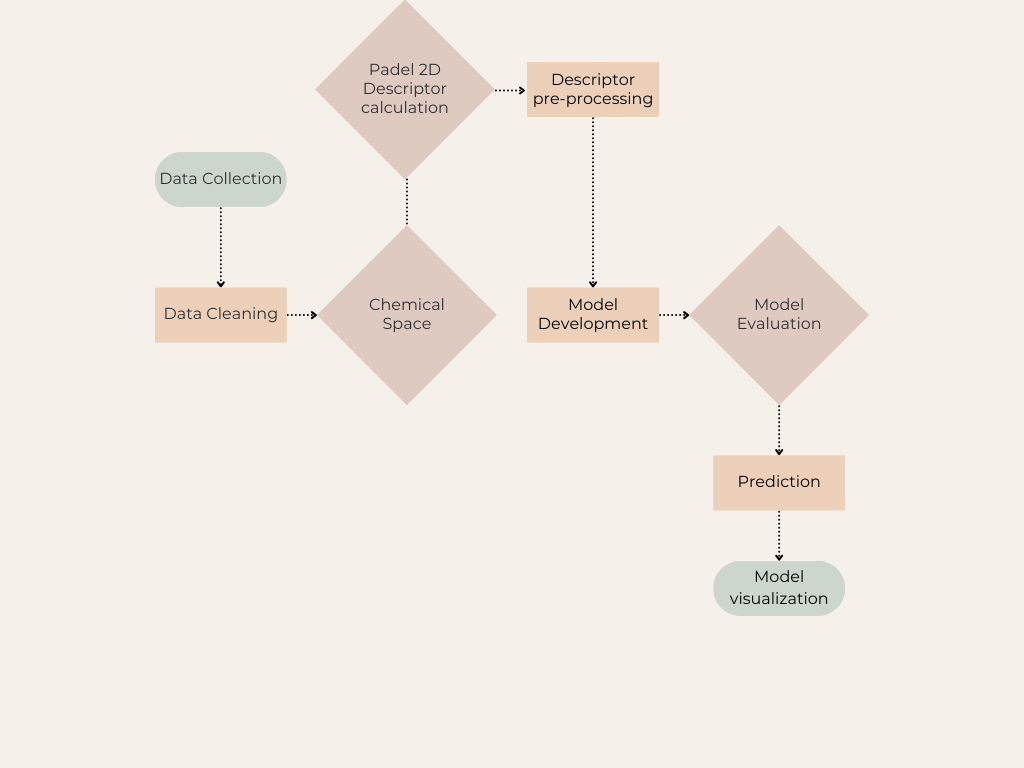


# Table of Contents <a id="home"></a>

- [Installing libraries](#installing-libraries)
- [Importing libraries](#importing-libraries)
- [Data collection](#data-collection)
- [Data pre-processing](#data-pre-processing)
- [Data cleaning](#data-cleaning)
- [Categorical/classification](#categorical-classification)
- [Substructure search](#substructure-search)
- [Data for ML](#data-for-ml)
- [Descriptor preprocessing](#descriptor-preprocessing)
- [Final data to be used for ML](#final-data-to-be-used-for-ml)
- [Descriptors using PCA](#descriptors-using-pca)
- [Descriptors using Filter method](#descriptors-using-filter-method)
- [Descriptors using RFE](#descriptors-using-rfe)
- [Final descriptors chosen to be used](#final-descriptors-chosen-to-be-used)
- [Final data to be used with correct descriptors](#final-data-to-be-used-with-correct-descriptors)
- [Machine learning/data splitting](#machine-learning-data-splitting)
- [Validation results discussion](#validation-results-discussion)
- [Hyperparameter tuning](#hyperparameter-tuning)
    - [Linear regression](#linear-regression)
    - [Ridge Regression](#ridge-regression)
    - [Elastic Net](#elastic-net)
    - [GBM](#gbm)
- [Hyperparameter discussion and choosing the optimal model](#hyperparameter-discussion-and-choosing-the-optimal-model)
- [Application Domain](#application-domain)
- [Y-scrambling](#y-scrambling)
- [Golbraikh and Tropsha thresholds](#golbraikh-and-tropsha-thresholds)
- [Conclusion](#conclusion)
- [Credits](#credits)


## Installing libraries

[top](#home)

Before we can start it is important that these libraries are installed. The libraries are commented out because they are already installed in my jupyter notebook.
We need the following libaries to be installed. 

- Pandas, Numpy: For data manipulation and analysis.
- Matplotlib & seaborn: For plotting and visualizations.
- RDKit: For cheminformatics tasks.
- Chembl-webresource-client: To access ChEMBL database.
- Tqdm: For progress bars in loops.
- Scikit-learn: For machine learning algorithms.
- XGBoost: For gradient boosting framework.
- LightGBM: For efficient gradient boosting.
- SHAP: For model interpretation using SHAP values.
- Padelpy: For molecular descriptor calculations.


In [39]:
# Using pip to install libraries
#!pip install pandas seaborn matplotlib rdkit chembl_webresource_client tqdm scikit-learn xgboost lightgbm shap padelpy

# Using conda
#!conda install -c conda-forge rdkit

## Importing libraries
[top](#home)
- - -

In [1]:
# Importing the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from tqdm import tqdm
from IPython.display import SVG

# RDKit for cheminformatics
from rdkit import Chem
from rdkit.Chem import AllChem, Draw, Descriptors, Lipinski, PandasTools
from rdkit.Chem.FilterCatalog import FilterCatalog, FilterCatalogParams
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import DataStructs
from rdkit.Avalon.pyAvalonTools import GetAvalonFP
from rdkit.Chem import rdmolops


# ChEMBL web resource client
from chembl_webresource_client.new_client import new_client 

# Machine learning libraries|
from sklearn.model_selection import train_test_split, cross_val_score, LeaveOneOut
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import (RandomForestRegressor, GradientBoostingRegressor,
                              StackingRegressor, BaggingRegressor, AdaBoostRegressor)
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
import xgboost as xgb 
import lightgbm as lgb  

#feature importance
from sklearn.inspection import permutation_importance
import shap
#application domain
from sklearn.metrics import pairwise_distances


from sklearn.metrics import (r2_score, mean_absolute_error, mean_squared_error)
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Padelpy for molecular descriptor calculations
from padelpy import padeldescriptor, from_smiles

# PubChem for chemical information retrieval
import pubchempy as pcp

# Additional libraries for data handling and visualization
import requests
import json
import math
import time  # To check time

# Hide warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# Set display options for Pandas DataFrames
pd.set_option('display.max_colwidth', None)  # None means no limit
sns.set(style="whitegrid")



<frozen importlib._bootstrap>:488: RuntimeWarning: to-Python converter for class boost::shared_ptr<class RDKit::FilterHierarchyMatcher> already registered; second conversion method ignored.


ModuleNotFoundError: No module named 'pubchempy'

## Data Collection
- - -

_[ChEMBL](https://www.ebi.ac.uk/chembl/) is an Open Data database containing binding, functional and ADMET information for a large number of drug-like bioactive compounds. The data is manually abstracted from the primary published literature on a regular basis, then further curated and standardized to maximize their quality and utility across a wide range of chemical biology and drug-discovery research problems. Currently, the database contains 5.4 million bioactivity measurements for more than 1 million compounds and 5200 protein targets.

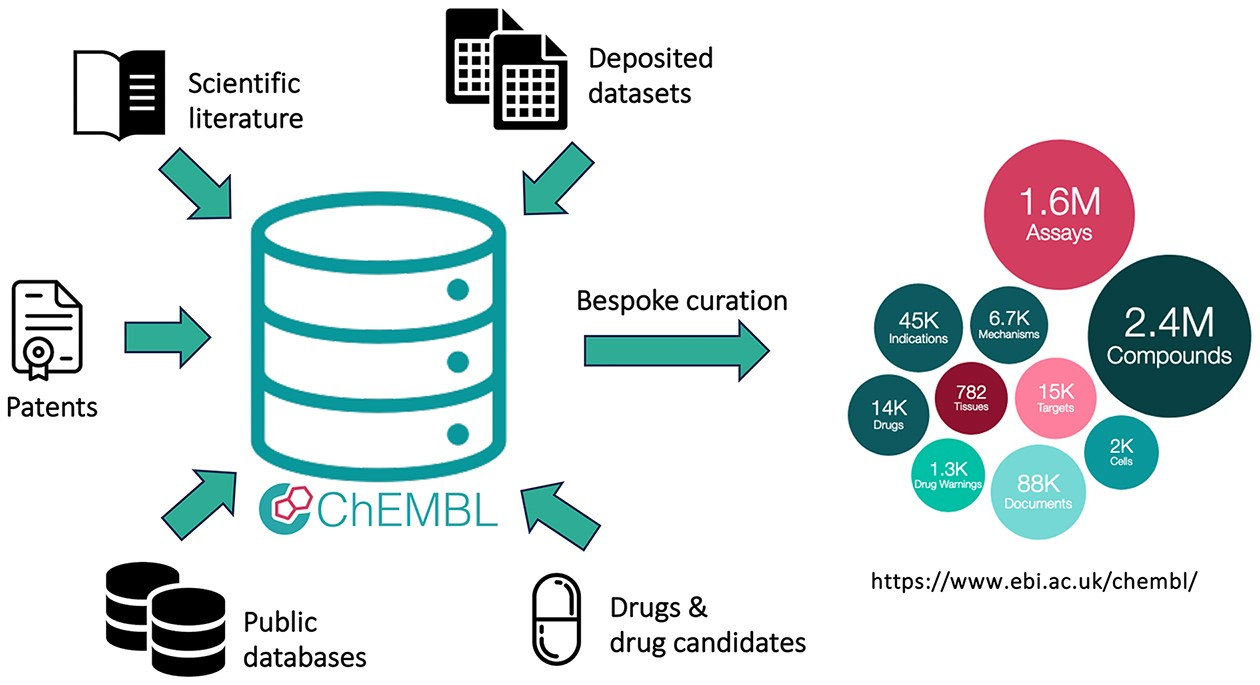 __[zdrazil et al., 2023](https://academic.oup.com/nar/article/52/D1/D1180/7337608)

### ChEMBL data

To ensure consistency in the data collection process, we have frozen the data into a CSV file. For reproducibility load the CSV named "chembl_targets_15_jul.csv" and jump the first step which is commented out. 

In [2]:
# #extract data from Chembl
# # target = new_client.target
# target_query = target.search('tuberculosis')
# targets = pd.DataFrame.from_dict(target_query)
# #preview extracted data
# targets

Loading the data stored.

In [ ]:
# Freeze targets by making a csv
#targets.to_csv('chembl_targets_15_jul.csv')
targets = pd.read_csv('chembl_targets_15_jul.csv')
targets.head(5)

In [4]:
targets.shape

(5, 10)

## Data pre-processing
---

We are interested in the data in the first and second rows which represent data from the strain from H37Rv. So I will selct the two rows.  

In [4]:
targets.iloc[[0,1]] #to get the first two rows

,Unnamed: 0,cross_references,organism,pref_name,score,species_group_flag,target_chembl_id,target_components,target_type,tax_id
0,0,[],Mycobacterium tuberculosis,Mycobacterium tuberculosis,15.0,False,CHEMBL360,[],ORGANISM,1773
1,1,[],Mycobacterium tuberculosis H37Rv,Mycobacterium tuberculosis H37Rv,13.0,False,CHEMBL2111188,[],ORGANISM,83332


In [5]:
#Selecting the target organism
selected_target1 = targets.target_chembl_id[0] #MTb
selected_target2 = targets.target_chembl_id[1] #Mtb H37RV
selected_target1, selected_target2

('CHEMBL360', 'CHEMBL2111188')

## Data Cleaning

### Data cleaning is an iterative process:


- Fitering the standard value according to the IC50
- transformed all the data of standard value to numeric value. this is important because when its in an object string format, statistical evaluation will not be done on the column.
-deleted 'standard_value' rows with blanks
- The dataset has a column "data_validity_comment" which helps to check the validity of the data captured, therefore, if the data is considered outside range we filtered it out. 
-further, when there are duplicates of the same data by "molecule_chembl_id" we would then take the smallest one.

In [6]:
#collecting data for using IC50
activity = new_client.activity
data1 = activity.filter(target_chembl_id=selected_target1).filter(standard_type='IC50') 
data2 = activity.filter(target_chembl_id=selected_target2).filter(standard_type='IC50')

I will then combine the two datasets into one dataframe

In [7]:
%%time
#converting dictionaries to pandas dataframes
df_1 = pd.DataFrame.from_dict(data1)
df_2 = pd.DataFrame.from_dict(data2)
#concatenating all the dataframes on top of each other (by rows)
df = pd.concat([df_1, df_2], axis=0, ignore_index=True)

Wall time: 3min 39s


In [8]:
#checking the shape of the dataset
df.shape

(2950, 46)

In [9]:
#transform standard_values to numeric
df['standard_value'] = pd.to_numeric(df['standard_value'], errors='coerce')

In [10]:
# delete blank rows
df= df.dropna(subset=['standard_value'])

In [11]:
# Filter out data 'Outside typical range'
df1 = df[df['data_validity_comment'] != 'Outside typical range']

#Select entry with the lowest standard_value
best_entries = df.groupby('molecule_chembl_id').apply(lambda x: x.nsmallest(1, 'standard_value')).reset_index(drop=True)

# If no valid entries are found, choose to keep the original duplicates 
if best_entries.empty:
    best_entries = df.groupby('molecule_chembl_id').first().reset_index()


In [12]:
best_entries.head(2)

,action_type,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,...,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,None,None,16421037,[],CHEMBL3750542,Antimycobacterial activity against Mycobacterium tuberculosis H37Ra ATCC 25177 assessed as growth inhibition after 24 to 168 hrs by microplate resazurin assay,F,None,None,BAO_0000190,...,Mycobacterium tuberculosis,Mycobacterium tuberculosis,1773,None,None,IC50,uM,UO_0000065,None,23.8
1,None,None,25507649,"[{'comments': None, 'relation': '=', 'result_flag': 0, 'standard_relation': '=', 'standard_text_value': None, 'standard_type': 'TIME', 'standard_units': 'hr', 'standard_value': '120.0', 'text_value': None, 'type': 'TIME', 'units': 'day', 'value': '5.0'}]",CHEMBL5333912,Antimycobacterial activity against Mycobacterium tuberculosis HN878 assessed as inhibition of mycobacterial growth incubated for 5 days,F,None,None,BAO_0000190,...,Mycobacterium tuberculosis,Mycobacterium tuberculosis,1773,None,None,IC50,uM,UO_0000065,None,25.0


### Data cleaning cont-

- Now we now filter according to the type of assay. we are only interested in only H37Ra/ H37Rv. the strain are chosen because we will be working with them experimentally.

In [13]:
#Taking only assay with 'h37ra|h37rv'
best_entries =   best_entries[  best_entries['assay_description'].str.contains(r'h37ra|h37rv',
                                                                               case=False, na=False)]

print(f'The shape of the dataset after filtering assay_description is: {best_entries.shape}')

The shape of the dataset after filtering assay_description is: (1378, 46)


From the columns we will select the columns that are of interest to us. Which are molecule_chembl_id', 'canonical_smiles', 'standard_value

In [14]:
#selecting only required columns
selection = ['molecule_chembl_id', 'canonical_smiles', 'standard_value']
best_entries= best_entries[selection]
best_entries.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1378 entries, 0 to 1913
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   molecule_chembl_id  1378 non-null   object 
 1   canonical_smiles    1378 non-null   object 
 2   standard_value      1378 non-null   float64
dtypes: float64(1), object(2)
memory usage: 43.1+ KB


Summary
- standard_value column
In the data cleaning we managed to make the standard_value into a numeric format, this is because only analysis can only be performed on numbers and not objects.The rows wich had empty rows were deleted.
- data_validity column
This column was used to filter data so that we get compounds that are within the range of what has been repoted by others, meaning data that is outside that had this comment was deleted. 
- Chembl_Id column
It was noticed that some compounds were captured more than twice and we filtered such data taking the IC50 which had lower values.

## Categorical/classification

According to a research article, the active concentration of isoniazid ranges from 0.1 to 0.2 µg/mL, which is equivalent to approximately 0.00729 to 1.458 µM.  Based on these findings, we will classify compounds as either active or inactive. Specifically, compounds with an IC50 value greater than 1456 nM will be classified as inactive. 

In [15]:
#classify activity into classes
bioactivity_class = []

for i in best_entries['standard_value']:
    if float(i) > 1456:
        bioactivity_class.append("inactive")
    else:  # This covers both equal to and less than 1456
        bioactivity_class.append("active")

# Optionally, you can add this classification as a new column in the DataFrame
best_entries['bioactivity_class'] = bioactivity_class

best_entries = best_entries[['molecule_chembl_id', 'canonical_smiles', 'standard_value', 'bioactivity_class']]
# Display the updated DataFrame
best_entries.head()

#print(df[['molecule_chembl_id', 'canonical_smiles', 'standard_value', 'bioactivity_class']])
 

,molecule_chembl_id,canonical_smiles,standard_value,bioactivity_class
0,CHEMBL105310,O=C(/C=C/c1ccccc1)c1ccc(O)cc1O,23800.0,inactive
3,CHEMBL1087717,COc1ccc(O)c(-c2csc(N/N=C(\C)c3ccncc3)n2)c1,100.0,active
4,CHEMBL1088462,COc1ccc2c(c1CC=C(C)C)O[C@H]1c3cc(CC=C(C)C)c(O)cc3OC[C@@]21O,12.5,active
5,CHEMBL1089834,COc1ccc2c(c1)[n+]([O-])c(C(=O)NCc1ccccc1)c(C)[n+]2[O-],18870.0,inactive
6,CHEMBL1089835,Cc1c(C(=O)NCc2ccccc2)[n+]([O-])c2cc(Cl)ccc2[n+]1[O-],1100.0,active


In [16]:
#make a copy of df just in case 
df2 = best_entries.copy()

In the cell below, we then visualize the active vs the inactive compounds, of which is represented by the bar graph.

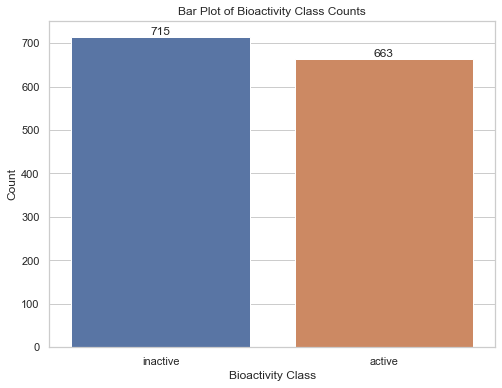

In [17]:
#visualize the class
df2_counts = df2['bioactivity_class'].value_counts()

# Creating a bar plot
plt.figure(figsize=(8, 6))
bar_plot = sns.barplot(x=df2_counts.index, y=df2_counts.values)
# Add count labels on top of the bars
for p in bar_plot.patches:
    bar_plot.annotate(f'{int(p.get_height())}', 
                      (p.get_x() + p.get_width() / 2., p.get_height()), 
                      ha='center', va='bottom')
    
plt.xlabel('Bioactivity Class')
plt.ylabel('Count')
plt.title('Bar Plot of Bioactivity Class Counts')
plt.show()


The plot indicates that 715 compounds of the compounds are active whils 663 compounds inactive. 

-Further, we plot the distribution of the compounds using the standard_value(IC50)


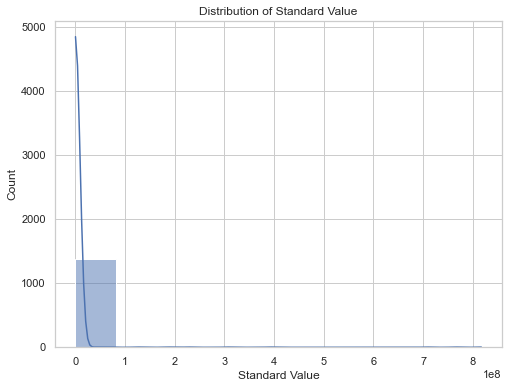

In [18]:
#Creatin a histogram
plt.figure(figsize=(8, 6))
sns.histplot(df2['standard_value'], bins=10, kde=True)  # kde=True adds a kernel density estimate

# Adding labels and title
plt.xlabel('Standard Value')
plt.ylabel('Count')
plt.title('Distribution of Standard Value')

# Display the plot
plt.show()

The distribuion using standard value is diffult to interpret and hence we convert it to the (-log)

In [19]:
#pIc50
df2['pIC50']= 9-np.log10(df2['standard_value'])


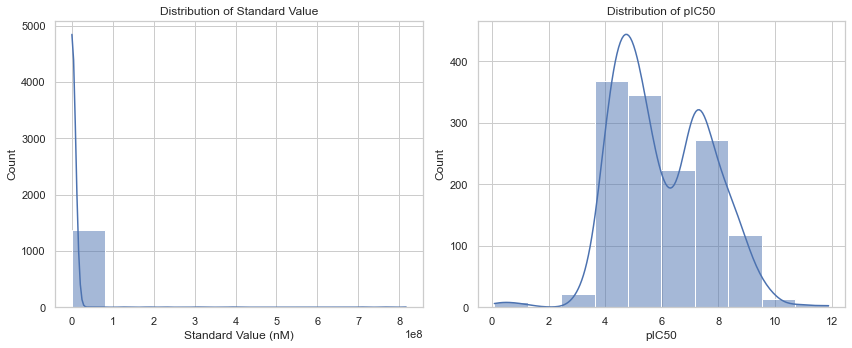

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

#histogram for standard_value
sns.histplot(df2['standard_value'], bins=10, ax=ax1, kde=True)
ax1.set_xlabel('Standard Value (nM)')
ax1.set_ylabel('Count')
ax1.set_title('Distribution of Standard Value')

#histogram for pIC50
sns.histplot(df2['pIC50'], bins=10, ax=ax2, kde=True)
ax2.set_xlabel('pIC50')
ax2.set_ylabel('Count')
ax2.set_title('Distribution of pIC50')

fig.savefig('histogram_distribution.png')

plt.tight_layout()
plt.show()

The higher the pIC50 corresponds to the lower IC50.

In [21]:
df2['pIC50'].describe()

count    1378.000000
mean        6.046510
std         1.678095
min         0.087700
25%         4.698970
50%         5.698970
75%         7.440910
max        11.886057
Name: pIC50, dtype: float64

In [22]:
df2.head(2)

,molecule_chembl_id,canonical_smiles,standard_value,bioactivity_class,pIC50
0,CHEMBL105310,O=C(/C=C/c1ccccc1)c1ccc(O)cc1O,23800.0,inactive,4.623423
3,CHEMBL1087717,COc1ccc(O)c(-c2csc(N/N=C(\C)c3ccncc3)n2)c1,100.0,active,7.000000


## Substructure search(Isoniazid)

Now that we have explored our datasets, we will then do a substructure search of the compound of interest, which the isoniazid. we further looked at deffrent derivatives of it when doing the substructure search  to ensure that we dont miss any derivative.

1.1 Substructure search using isoniazid smile

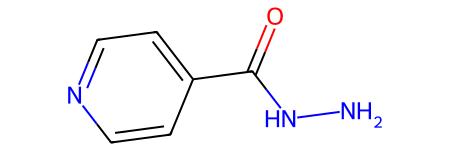

In [23]:
isoniazid_smile = Chem.MolFromSmiles('C1=CN=CC=C1C(=O)NN')
isoniazid_smile

In [24]:
%%time
# List to store results
match_ = []

for index, row in df2.iterrows():
    mol = Chem.MolFromSmiles(row['canonical_smiles'])
    if mol is not None and mol.HasSubstructMatch(isoniazid_smile):
        match = mol.GetSubstructMatch(isoniazid_smile)
        match_.append((index, row['canonical_smiles'], match))

for index, smiles, match in match_:
    print(f"Index: {index}, SMILES: {smiles}, Match: {match}")

matched_indices = [m[0] for m in match_]  
matched_df_1 = df2.loc[matched_indices]      # Filter df3 to include only matched rows

Index: 51, SMILES: N#Cc1ccc(Nc2ncnc3c(=N)n(NC(=O)c4ccncc4)cnc23)cc1, Match: (19, 20, 21, 22, 23, 18, 16, 17, 15, 14)
Index: 56, SMILES: N=c1c2ncnc(Nc3ccccc3)c2ncn1NC(=O)c1ccncc1, Match: (22, 23, 24, 25, 26, 21, 19, 20, 18, 17)
Index: 59, SMILES: N=c1c2ncnc(Nc3ccc(F)cc3)c2ncn1NC(=O)c1ccncc1, Match: (23, 24, 25, 26, 27, 22, 20, 21, 19, 18)
Index: 63, SMILES: COc1ccc(Nc2ncnc3c(=N)n(NC(=O)c4ccncc4)cnc23)cc1, Match: (19, 20, 21, 22, 23, 18, 16, 17, 15, 14)
Index: 152, SMILES: Cc1c(/C=N/NC(=O)c2ccncc2)[n+]([O-])c2ccccc2[n+]1[O-], Match: (9, 10, 11, 12, 13, 8, 6, 7, 5, 4)
Index: 153, SMILES: Cc1c(/C=N/NC(=O)c2ccncc2)[n+]([O-])c2cc(Cl)ccc2[n+]1[O-], Match: (9, 10, 11, 12, 13, 8, 6, 7, 5, 4)
Index: 154, SMILES: COc1ccc2c(c1)[n+]([O-])c(/C=N/NC(=O)c1ccncc1)c(C)[n+]2[O-], Match: (17, 18, 19, 20, 21, 16, 14, 15, 13, 12)
Index: 155, SMILES: Cc1ccc2c(c1)[n+]([O-])c(/C=N/NC(=O)c1ccncc1)c(C)[n+]2[O-], Match: (16, 17, 18, 19, 20, 15, 13, 14, 12, 11)
Index: 156, SMILES: Cc1cc2c(cc1C)[n+]([O-])c(/C=N/NC(

In [25]:
matched_df_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35 entries, 51 to 1905
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   molecule_chembl_id  35 non-null     object 
 1   canonical_smiles    35 non-null     object 
 2   standard_value      35 non-null     float64
 3   bioactivity_class   35 non-null     object 
 4   pIC50               35 non-null     float64
dtypes: float64(2), object(3)
memory usage: 1.6+ KB


## Substructure search using isoniazid derivative 

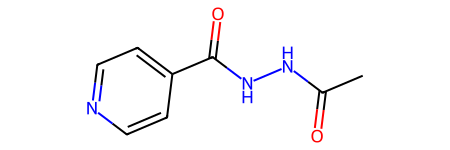

In [26]:
isoniazid_der1 = Chem.MolFromSmiles('C1=CN=CC=C1C(=O)NNC(=O)C')
isoniazid_der1

In [27]:
# List to store results
iso_der1 = []
s
for index, row in df2.iterrows():
    mol = Chem.MolFromSmiles(row['canonical_smiles'])
    if mol is not None and mol.HasSubstructMatch(isoniazid_der1):
        match = mol.GetSubstructMatch(isoniazid_der1)
        iso_der1.append((index, row['canonical_smiles'], match))

for index, smiles, match in iso_der1:

    matched_indices_iso = [m[0] for m in iso_der1]  
    matched_df_der1 = df2.loc[matched_indices_iso]      


In [28]:
matched_df_der1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1 entries, 619 to 619
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   molecule_chembl_id  1 non-null      object 
 1   canonical_smiles    1 non-null      object 
 2   standard_value      1 non-null      float64
 3   bioactivity_class   1 non-null      object 
 4   pIC50               1 non-null      float64
dtypes: float64(2), object(3)
memory usage: 48.0+ bytes


## Substructure search using isoniazid derivative 2

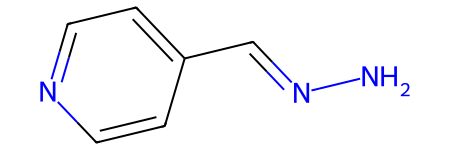

In [29]:
isoniazid_der2 = Chem.MolFromSmiles('C1=CN=CC=C1C=NN')
isoniazid_der2

In [30]:
iso_der2 = []

for index, row in df2.iterrows():
    mol = Chem.MolFromSmiles(row['canonical_smiles'])
    if mol is not None and mol.HasSubstructMatch(isoniazid_der2):
        match = mol.GetSubstructMatch(isoniazid_der2)
        iso_der2.append((index, row['canonical_smiles'], match))

for index, smiles, match in iso_der2:
    
    matched_indices_der2 = [m[0] for m in iso_der2]  
    matched_df_der2 = df2.loc[matched_indices_der2]      


In [31]:
matched_df_der2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25 entries, 3 to 1103
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   molecule_chembl_id  25 non-null     object 
 1   canonical_smiles    25 non-null     object 
 2   standard_value      25 non-null     float64
 3   bioactivity_class   25 non-null     object 
 4   pIC50               25 non-null     float64
dtypes: float64(2), object(3)
memory usage: 1.2+ KB


## Substructure search derivative 4

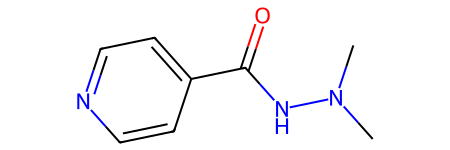

In [32]:
isoniazid_der3 = Chem.MolFromSmiles('C1=CN=CC=C1C(=O)NN(C)C')
isoniazid_der3

In [33]:

iso_der3 = []


for index, row in df2.iterrows():
    mol = Chem.MolFromSmiles(row['canonical_smiles'])
    if mol is not None and mol.HasSubstructMatch(isoniazid_der3):
        match = mol.GetSubstructMatch(isoniazid_der3)
        iso_der3.append((index, row['canonical_smiles'], match))

3
matched_indices_der3 = [m[0] for m in iso_der3]  
matched_der3 = df2.loc[matched_indices_der3]

for index, smiles, match in iso_der3:
    print(f"Index: {index}, SMILES: {smiles}, Match: {match}")



In [34]:
matched_der3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   molecule_chembl_id  0 non-null      object 
 1   canonical_smiles    0 non-null      object 
 2   standard_value      0 non-null      float64
 3   bioactivity_class   0 non-null      object 
 4   pIC50               0 non-null      float64
dtypes: float64(2), object(3)
memory usage: 0.0+ bytes


Now, I will then merge all the dfs of the subtructure searches, removing duplicates.

In [35]:
#Now I combine all the df on their indexes

filtered_data = pd.concat([matched_df_1, matched_df_der1, matched_df_der2]).drop_duplicates()
filtered_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60 entries, 51 to 1103
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   molecule_chembl_id  60 non-null     object 
 1   canonical_smiles    60 non-null     object 
 2   standard_value      60 non-null     float64
 3   bioactivity_class   60 non-null     object 
 4   pIC50               60 non-null     float64
dtypes: float64(2), object(3)
memory usage: 2.8+ KB


In [36]:
filtered_data = filtered_data.reset_index(drop =True)

In [37]:
filtered_data.set_index('molecule_chembl_id', inplace=True)


In [38]:
filtered_data.head()

,canonical_smiles,standard_value,bioactivity_class,pIC50
molecule_chembl_id,,,,
CHEMBL1170766,N#Cc1ccc(Nc2ncnc3c(=N)n(NC(=O)c4ccncc4)cnc23)cc1,17.20,active,7.764472
CHEMBL1171167,N=c1c2ncnc(Nc3ccccc3)c2ncn1NC(=O)c1ccncc1,4.30,active,8.366532
CHEMBL1172293,N=c1c2ncnc(Nc3ccc(F)cc3)c2ncn1NC(=O)c1ccncc1,0.91,active,9.040959
CHEMBL1172698,COc1ccc(Nc2ncnc3c(=N)n(NC(=O)c4ccncc4)cnc23)cc1,1.59,active,8.798603
CHEMBL1777913,Cc1c(/C=N/NC(=O)c2ccncc2)[n+]([O-])c2ccccc2[n+]1[O-],1170.00,active,5.931814


In [39]:
filtered_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 60 entries, CHEMBL1170766 to CHEMBL3782032
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   canonical_smiles   60 non-null     object 
 1   standard_value     60 non-null     float64
 2   bioactivity_class  60 non-null     object 
 3   pIC50              60 non-null     float64
dtypes: float64(2), object(2)
memory usage: 2.3+ KB


### Notes
After the substructure search, the dataset had now 60 rows, and 4 columns. now, i will check if the isoniazid is contained in the filtered data so that if it is there I will not merge it with the data obtained from the pubchem data.

In [40]:
filtered_data.loc[['CHEMBL64']]

,canonical_smiles,standard_value,bioactivity_class,pIC50
molecule_chembl_id,,,,
CHEMBL64,NNC(=O)c1ccncc1,0.0013,active,11.886057


We have the compound then theres no need to merge

In [41]:

PandasTools.AddMoleculeColumnToFrame(filtered_data, smilesCol='canonical_smiles', molCol='molecule')


PandasTools.ChangeMoleculeRendering(renderer='png') 
filtered_data.head()

,canonical_smiles,standard_value,bioactivity_class,pIC50,molecule
molecule_chembl_id,,,,,
CHEMBL1170766,N#Cc1ccc(Nc2ncnc3c(=N)n(NC(=O)c4ccncc4)cnc23)cc1,17.20,active,7.764472,<rdkit.Chem.rdchem.Mol object at 0x00000299302DD270>
CHEMBL1171167,N=c1c2ncnc(Nc3ccccc3)c2ncn1NC(=O)c1ccncc1,4.30,active,8.366532,<rdkit.Chem.rdchem.Mol object at 0x00000299302DD3C0>
CHEMBL1172293,N=c1c2ncnc(Nc3ccc(F)cc3)c2ncn1NC(=O)c1ccncc1,0.91,active,9.040959,<rdkit.Chem.rdchem.Mol object at 0x00000299302DD430>
CHEMBL1172698,COc1ccc(Nc2ncnc3c(=N)n(NC(=O)c4ccncc4)cnc23)cc1,1.59,active,8.798603,<rdkit.Chem.rdchem.Mol object at 0x00000299302DD4A0>
CHEMBL1777913,Cc1c(/C=N/NC(=O)c2ccncc2)[n+]([O-])c2ccccc2[n+]1[O-],1170.00,active,5.931814,<rdkit.Chem.rdchem.Mol object at 0x00000299302DD510>


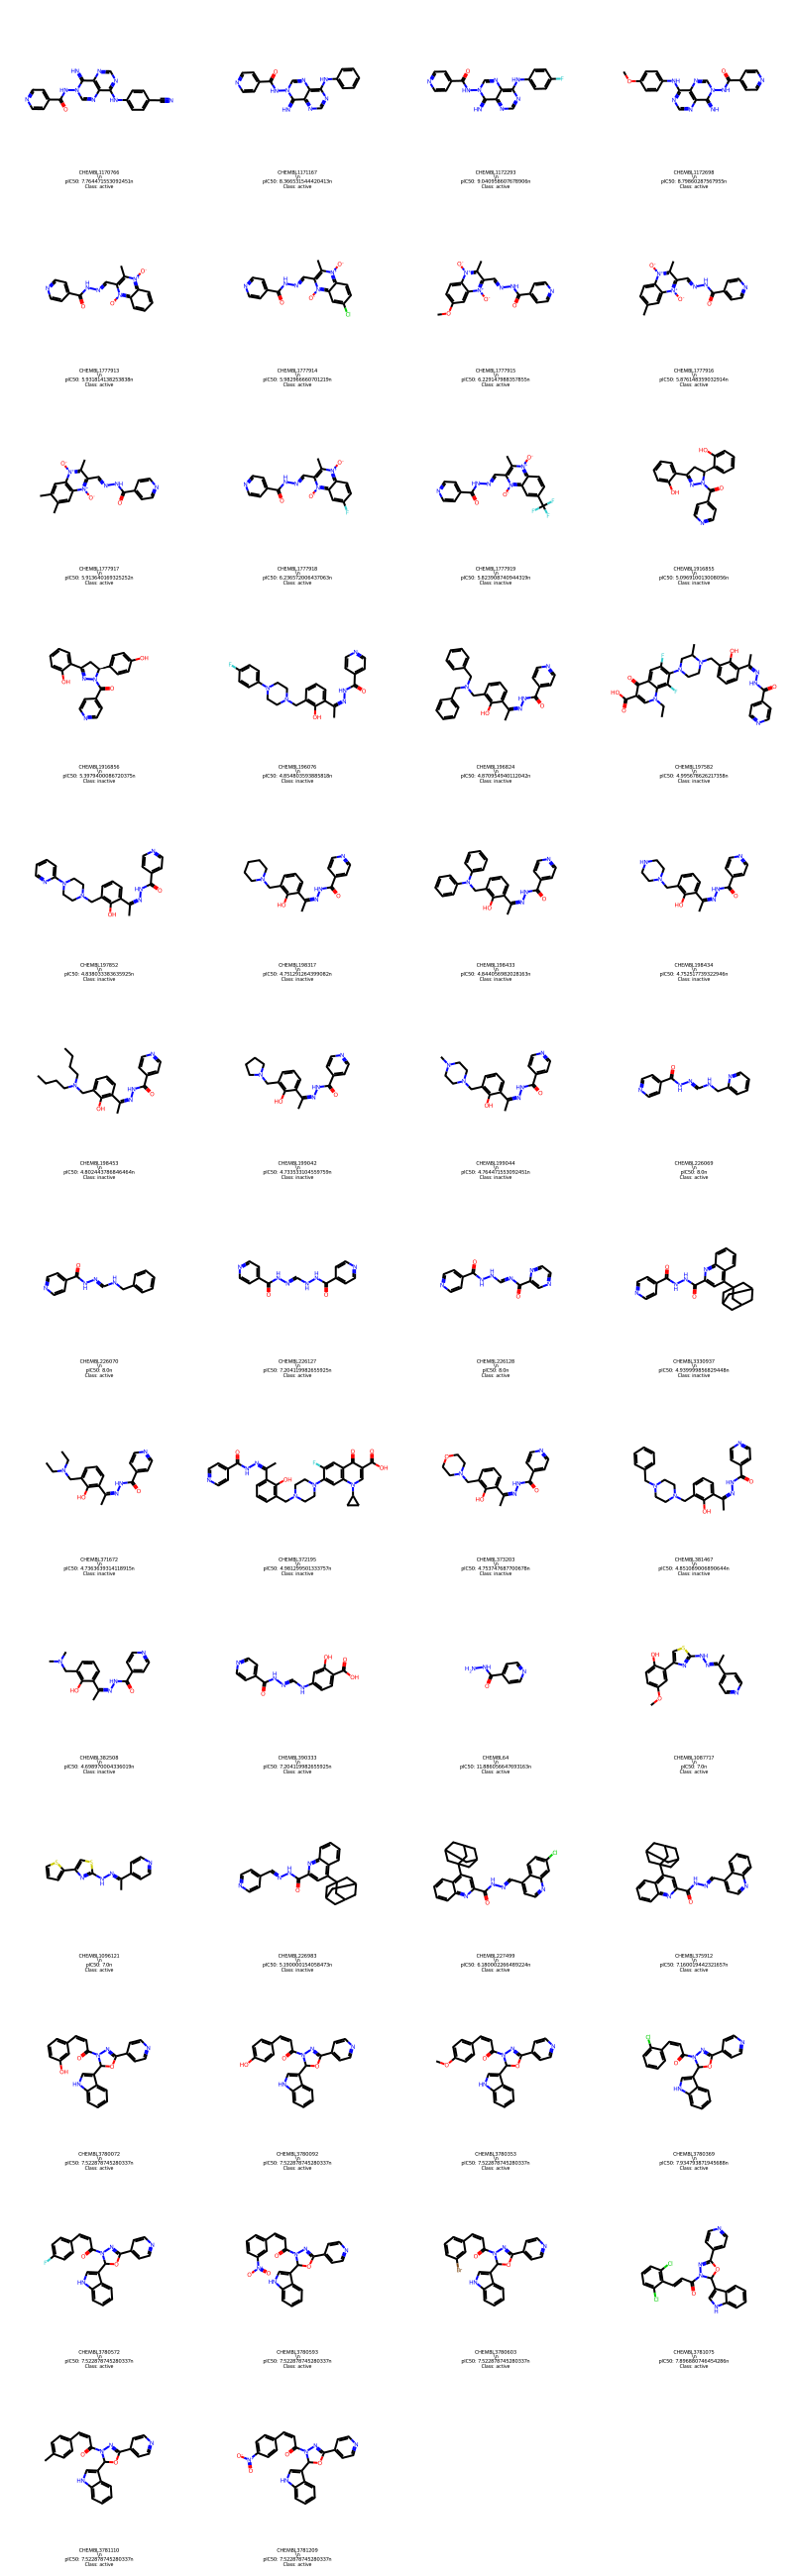

In [42]:
#function to visualize the molecules

legends = [f"{index}\n\n\\n\n\n\npIC50: {row['pIC50']}n\n\n\nClass: {row['bioactivity_class']}" for index, row in filtered_data.iterrows()]
img = Draw.MolsToGridImage(filtered_data['molecule'], 
                            legends=legends, 
                            molsPerRow=4, 
                            subImgSize=(200, 200))

display(img)

## The data is now clean and it ready for ML

-The first step is to verify the smiles if they are in the correct format

In [43]:
def validate_smiles(smiles):
    if pd.isna(smiles):  
        return None
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None 
    return smiles  

# Apply the function to the DataFrame
filtered_data['validated_smiles'] = filtered_data['canonical_smiles'].apply(validate_smiles)

# Filter out rows with blanks(Nan)
df_cleaned = filtered_data.dropna(subset=['validated_smiles'])

In [44]:
df_cleaned

,canonical_smiles,standard_value,bioactivity_class,pIC50,molecule,validated_smiles
molecule_chembl_id,,,,,,
CHEMBL1170766,N#Cc1ccc(Nc2ncnc3c(=N)n(NC(=O)c4ccncc4)cnc23)cc1,17.2000,active,7.764472,<rdkit.Chem.rdchem.Mol object at 0x00000299302DD270>,N#Cc1ccc(Nc2ncnc3c(=N)n(NC(=O)c4ccncc4)cnc23)cc1
CHEMBL1171167,N=c1c2ncnc(Nc3ccccc3)c2ncn1NC(=O)c1ccncc1,4.3000,active,8.366532,<rdkit.Chem.rdchem.Mol object at 0x00000299302DD3C0>,N=c1c2ncnc(Nc3ccccc3)c2ncn1NC(=O)c1ccncc1
CHEMBL1172293,N=c1c2ncnc(Nc3ccc(F)cc3)c2ncn1NC(=O)c1ccncc1,0.9100,active,9.040959,<rdkit.Chem.rdchem.Mol object at 0x00000299302DD430>,N=c1c2ncnc(Nc3ccc(F)cc3)c2ncn1NC(=O)c1ccncc1
CHEMBL1172698,COc1ccc(Nc2ncnc3c(=N)n(NC(=O)c4ccncc4)cnc23)cc1,1.5900,active,8.798603,<rdkit.Chem.rdchem.Mol object at 0x00000299302DD4A0>,COc1ccc(Nc2ncnc3c(=N)n(NC(=O)c4ccncc4)cnc23)cc1
CHEMBL1777913,Cc1c(/C=N/NC(=O)c2ccncc2)[n+]([O-])c2ccccc2[n+]1[O-],1170.0000,active,5.931814,<rdkit.Chem.rdchem.Mol object at 0x00000299302DD510>,Cc1c(/C=N/NC(=O)c2ccncc2)[n+]([O-])c2ccccc2[n+]1[O-]
CHEMBL1777914,Cc1c(/C=N/NC(=O)c2ccncc2)[n+]([O-])c2cc(Cl)ccc2[n+]1[O-],1040.0000,active,5.982967,<rdkit.Chem.rdchem.Mol object at 0x00000299302DD580>,Cc1c(/C=N/NC(=O)c2ccncc2)[n+]([O-])c2cc(Cl)ccc2[n+]1[O-]
CHEMBL1777915,COc1ccc2c(c1)[n+]([O-])c(/C=N/NC(=O)c1ccncc1)c(C)[n+]2[O-],590.0000,active,6.229148,<rdkit.Chem.rdchem.Mol object at 0x00000299302DD5F0>,COc1ccc2c(c1)[n+]([O-])c(/C=N/NC(=O)c1ccncc1)c(C)[n+]2[O-]
CHEMBL1777916,Cc1ccc2c(c1)[n+]([O-])c(/C=N/NC(=O)c1ccncc1)c(C)[n+]2[O-],1330.0000,active,5.876148,<rdkit.Chem.rdchem.Mol object at 0x00000299302DD660>,Cc1ccc2c(c1)[n+]([O-])c(/C=N/NC(=O)c1ccncc1)c(C)[n+]2[O-]
CHEMBL1777917,Cc1cc2c(cc1C)[n+]([O-])c(/C=N/NC(=O)c1ccncc1)c(C)[n+]2[O-],1220.0000,active,5.913640,<rdkit.Chem.rdchem.Mol object at 0x00000299302DD6D0>,Cc1cc2c(cc1C)[n+]([O-])c(/C=N/NC(=O)c1ccncc1)c(C)[n+]2[O-]


The SMILES are alright, I will continue with generating descriptors. I will use 2d and Fingerprints

In [45]:
%%time
#create a .smi file
df_cleaned['canonical_smiles'].to_csv('smiles.smi', index=None, header=None) 

Wall time: 18.3 ms


In [46]:
%%timeit

padeldescriptor(mol_dir='smiles.smi', d_file='descriptors_.csv', d_2d=True, d_3d=False, fingerprints=True, retainorder=True,
#                 convert3d=False, #detectaromaticity=True, removesalt=True, retain3d=True,
#                 # standardizenitro=True, standardizetautomers=True
               )

36.8 s ± 1.28 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


The descriptors are now created, I will then load them.

In [47]:
descriptors = pd.read_csv('descriptors_.csv')
descriptors.head()

,Name,nAcid,ALogP,ALogp2,AMR,apol,naAromAtom,nAromBond,nAtom,nHeavyAtom,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,AUTOGEN_smiles_1,0,-1.4971,2.241308,25.6387,52.810309,22,23,42,29,...,0,0,0,0,0,0,0,0,0,0
1,AUTOGEN_smiles_2,0,-1.5318,2.346411,19.4401,50.617102,22,23,41,27,...,0,0,0,0,0,0,0,0,0,0
2,AUTOGEN_smiles_3,0,-1.0521,1.106914,20.3126,50.507309,22,23,41,28,...,0,0,0,0,0,0,0,0,0,0
3,AUTOGEN_smiles_4,0,-1.5836,2.507789,26.7559,54.512688,22,23,45,29,...,0,0,0,0,0,0,0,0,0,0
4,AUTOGEN_smiles_5,0,-1.0133,1.026777,24.6150,44.734309,16,17,37,24,...,0,0,0,0,0,0,0,0,0,0


In [48]:
#the first column is then droped as it has no value
desc= descriptors.drop(descriptors.columns[0], axis= 1)

In [49]:
desc.head(2)

,nAcid,ALogP,ALogp2,AMR,apol,naAromAtom,nAromBond,nAtom,nHeavyAtom,nH,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,0,-1.4971,2.241308,25.6387,52.810309,22,23,42,29,13,...,0,0,0,0,0,0,0,0,0,0
1,0,-1.5318,2.346411,19.4401,50.617102,22,23,41,27,14,...,0,0,0,0,0,0,0,0,0,0


## Descriptor preprocessing

In [50]:
def preprocess_descriptors(df):
    """
    function to clean and preprocess the descriptors: 
    -Removes null values
    -convent boolen
    -removes zero variance
    -deletes highly correlated descriptors

    Parameters:
    The DF containing molecular descriptors.

    Returns:
    pandas.DF: The processed DataFrame after applying all preprocessing steps.
    """
    
    # Checking for null values and deleting
    null_count = df.isnull().sum().sum()  
    if null_count > 0:
        df.dropna(inplace=True)
        print(f"Number of null values deleted: {null_count}")
    else:
        print("No null values found.")

    # object and boolean types data type
    for column in df.select_dtypes(include=['object', 'bool']).columns:
        if df[column].dtype == 'bool':
            # use dummies 0,1 to convert
            df[column] = df[column].astype(int)
        elif df[column].dtype == 'object':
            # delete rows not object/bolean
            df.drop(columns=column, inplace=True)
            print(f"Deleted non-numeric column: {column}")

    # deleting zero variace values
    def remove_constant_values(df):
        # Identify columns with only one unique value
        constant_columns = [i for i in df.columns if len(df[i].unique()) == 1]
        
    
        new_df = df.drop(columns=constant_columns)
        
        print(f"Number of columns deleted due to constant values: {len(constant_columns)}")
        
        return new_df 

    # Applying the function 
    df = remove_constant_values(df)

    #checking for correlation of descriptors
    def check_correlated_descriptors(df, threshold=0.9):
        correlated_pairs = set()
        
        corr_matrix = df.corr()
        
        for i in range(len(corr_matrix.columns)):
            for j in range(i):
                
                if abs(corr_matrix.iloc[i, j]) > threshold:
                    colname = corr_matrix.columns[i]
                    correlated_pairs.add(colname)
        
        return correlated_pairs

    # Check for correlated features with a threshold of 0.9
    corr_features = check_correlated_descriptors(df, 0.9)

    print(f"Number of correlated features found: {len(corr_features)}")

    df = df.drop(columns=corr_features)

    return df  # Return the final processed DataFrame

#timing
start_time = time.time()
processed_df = preprocess_descriptors(desc)

# End time
end_time = time.time()

# Calculate total time taken
total_time = end_time - start_time
print(f"Total time taken for preprocessing: {total_time:.2f} seconds")


processed_df.head()

No null values found.
Number of columns deleted due to constant values: 915
Number of correlated features found: 1004
Total time taken for preprocessing: 26.02 seconds


,nAcid,ALogP,ALogp2,AMR,apol,naAromAtom,nN,nO,nS,nF,...,PubchemFP721,PubchemFP729,PubchemFP737,PubchemFP738,PubchemFP739,PubchemFP742,PubchemFP750,PubchemFP752,PubchemFP755,PubchemFP759
0,0,-1.4971,2.241308,25.6387,52.810309,22,9,1,0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,0,-1.5318,2.346411,19.4401,50.617102,22,8,1,0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,0,-1.0521,1.106914,20.3126,50.507309,22,8,1,0,1.0,...,0,0,0,0,0,0,0,0,0,0
3,0,-1.5836,2.507789,26.7559,54.512688,22,8,2,0,0.0,...,1,0,0,0,0,0,0,0,0,0
4,0,-1.0133,1.026777,24.6150,44.734309,16,5,3,0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [57]:
filtered_data.shape

(60, 6)

In [58]:
# Reset indices 
filtered_data_reset = filtered_data.iloc[:, :4].reset_index(drop=False)
processed_df_reset = processed_df.reset_index(drop=True)

# Concatenate 2 dfs
df_ml = pd.concat([filtered_data_reset, processed_df_reset], axis=1)
df_ml.to_csv('ml_data.csv')

- We have now cleaned our data/descriptors and we can now ready it for ML. The data is stored as CSV so that we dont have to do the process of cleaning again. 
- Now we start the process of identifying the relevant descriptors.

#### Note! When loading data for ML load using the code below

In [9]:
df= pd.read_csv('ml_data.csv')
df = df.drop(df.columns[0], axis =1)
df.head()

,molecule_chembl_id,canonical_smiles,standard_value,bioactivity_class,pIC50,nAcid,ALogP,ALogp2,AMR,apol,...,PubchemFP721,PubchemFP729,PubchemFP737,PubchemFP738,PubchemFP739,PubchemFP742,PubchemFP750,PubchemFP752,PubchemFP755,PubchemFP759
0,CHEMBL1170766,N#Cc1ccc(Nc2ncnc3c(=N)n(NC(=O)c4ccncc4)cnc23)cc1,17.20,active,7.764472,0,-1.4971,2.241308,25.6387,52.810309,...,0,0,0,0,0,0,0,0,0,0
1,CHEMBL1171167,N=c1c2ncnc(Nc3ccccc3)c2ncn1NC(=O)c1ccncc1,4.30,active,8.366532,0,-1.5318,2.346411,19.4401,50.617102,...,0,0,0,0,0,0,0,0,0,0
2,CHEMBL1172293,N=c1c2ncnc(Nc3ccc(F)cc3)c2ncn1NC(=O)c1ccncc1,0.91,active,9.040959,0,-1.0521,1.106914,20.3126,50.507309,...,0,0,0,0,0,0,0,0,0,0
3,CHEMBL1172698,COc1ccc(Nc2ncnc3c(=N)n(NC(=O)c4ccncc4)cnc23)cc1,1.59,active,8.798603,0,-1.5836,2.507789,26.7559,54.512688,...,1,0,0,0,0,0,0,0,0,0
4,CHEMBL1777913,Cc1c(/C=N/NC(=O)c2ccncc2)[n+]([O-])c2ccccc2[n+...,1170.00,active,5.931814,0,-1.0133,1.026777,24.6150,44.734309,...,0,0,0,0,0,0,0,0,0,0


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Columns: 411 entries, molecule_chembl_id to PubchemFP759
dtypes: float64(324), int64(84), object(3)
memory usage: 192.8+ KB


- It is important to know which compounds we are dealing with, therefore we will set the ChEMBL ID as the index.

In [14]:
df.set_index('molecule_chembl_id', inplace=True)

- We remove this columns as we will not use them in our Ml regression.

In [17]:
df = df.drop(columns=['canonical_smiles','standard_value', 'bioactivity_class'])


In [19]:
df.head()

,pIC50,nAcid,ALogP,ALogp2,AMR,apol,naAromAtom,nN,nO,nS,...,PubchemFP721,PubchemFP729,PubchemFP737,PubchemFP738,PubchemFP739,PubchemFP742,PubchemFP750,PubchemFP752,PubchemFP755,PubchemFP759
molecule_chembl_id,,,,,,,,,,,,,,,,,,,,,
CHEMBL1170766,7.764472,0,-1.4971,2.241308,25.6387,52.810309,22,9,1,0,...,0,0,0,0,0,0,0,0,0,0
CHEMBL1171167,8.366532,0,-1.5318,2.346411,19.4401,50.617102,22,8,1,0,...,0,0,0,0,0,0,0,0,0,0
CHEMBL1172293,9.040959,0,-1.0521,1.106914,20.3126,50.507309,22,8,1,0,...,0,0,0,0,0,0,0,0,0,0
CHEMBL1172698,8.798603,0,-1.5836,2.507789,26.7559,54.512688,22,8,2,0,...,1,0,0,0,0,0,0,0,0,0
CHEMBL1777913,5.931814,0,-1.0133,1.026777,24.6150,44.734309,16,5,3,0,...,0,0,0,0,0,0,0,0,0,0


- We now going to set our variables X and y for Ml. we will use sharp and permutation importance using Rf.

In [9]:
df2= df.copy()

In [21]:
#df2 = df2.drop('pIC50', axis = 'columns')


In [23]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np

X = df2.values

# Standardizing descriptors
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fitting PCA
pca = PCA()
pca.fit(X_scaled)

# Get PCA components
loadings = pca.components_

# Converting to df
loadings_df = pd.DataFrame(loadings, columns=df2.columns)

#contributing descriptors per PC
abs_loadings = loadings_df.abs()

# Print top 5 descriptors per first 5 principal components
for i in range(5):
    print(f"Top descriptors for PC{i+1}:")
    print(abs_loadings.iloc[i].sort_values(ascending=False).head(5))
    print()

#explained variance ratio of PCs
print("Explained variance ratio per PC:")
print(pca.explained_variance_ratio_)


Top descriptors for PC1:
SCH-6     0.116528
AATS1i    0.113740
hmin      0.108799
AATS3i    0.108689
AATS0i    0.108683
Name: 0, dtype: float64

Top descriptors for PC2:
pIC50      0.114374
AMR        0.113037
ATSC7c     0.111748
nRotBt     0.110420
AATSC7c    0.110151
Name: 1, dtype: float64

Top descriptors for PC3:
AATS6e        0.127791
AATS0e        0.124480
ETA_EtaP_F    0.117047
MIC1          0.114948
SM1_DzZ       0.111643
Name: 2, dtype: float64

Top descriptors for PC4:
C3SP3           0.132574
SpMin1_Bhm      0.124897
PubchemFP548    0.124186
VE1_Dzp         0.120226
PubchemFP494    0.118627
Name: 3, dtype: float64

Top descriptors for PC5:
naaN       0.145429
nHBAcc     0.143749
nHdNH      0.130380
naasN      0.129038
MDEN-22    0.125748
Name: 4, dtype: float64

Explained variance ratio per PC:
[1.58080957e-01 1.28078152e-01 1.11716653e-01 8.82650875e-02
 7.29435581e-02 5.78448847e-02 3.81116206e-02 3.51472493e-02
 3.33205076e-02 2.71706918e-02 2.51410167e-02 2.00671768e-02

check if the assignement of X and y variable is succesful.

In [108]:
features_to_use = list(['SCH-6','AATS1i','hmin','AATS3i',
'AATS0i','AMR','nRotBt','ATSC7c','ETA_Eta_B','nHBint7','AATS6e','AATS0e',
'ETA_EtaP_F',
'MIC1',
'ETA_dEpsilon_B', 'C3SP3',
'SpMin1_Bhm',
'PubchemFP548',
'VE1_Dzp',
'PubchemFP494',
'naaN',
'nHBAcc',
'nHdNH',
'naasN',
'MDEN-22'])

In [110]:
len(features_to_use)

25

## VIF
We did not continue with this as we got all the descriptors with high VIF meaning, we had to delete all. 

In [102]:
# X = df[features_to_use]
# from statsmodels.stats.outliers_influence import variance_inflation_factor
# from statsmodels.tools.tools import add_constant

# # Add a constant for intercept
# x = add_constant(X)

# # Calculate VIF for each feature
# vif_data = pd.DataFrame()
# vif_data["features"] = x.columns
# vif_data["VIF"] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]

# # Display the results
# print(vif_data)

          features           VIF
0            const  51280.895229
1            SCH-6     84.955904
2           AATS1i     50.932015
3             hmin    132.904054
4           AATS3i     30.993682
5           AATS0i     47.967311
6              AMR    100.744516
7           nRotBt     21.056895
8           ATSC7c     10.704556
9        ETA_Eta_B     52.911975
10         nHBint7     16.170175
11          AATS6e     48.329985
12          AATS0e    216.291294
13      ETA_EtaP_F     64.047011
14            MIC1     14.350472
15  ETA_dEpsilon_B    162.011145
16           C3SP3     56.583624
17      SpMin1_Bhm     55.682710
18    PubchemFP548     19.315372
19         VE1_Dzp     11.204482
20    PubchemFP494     12.267667
21            naaN     35.885685
22          nHBAcc     22.293311
23           nHdNH     44.138576
24           naasN     23.534358
25         MDEN-22     39.435840


Then we delete features that have VIF>10

In [72]:
# #deleting features with VIF avove 10
# vif_data =vif_data[vif_data['VIF'] <= 10]
# vif_data

,features,VIF


In [76]:
# features = vif_data['features']
# features = features.to_list()
# features

['const',
 'SCH-6',
 'AATS1i',
 'hmin',
 'AATS3i',
 'AATS0i',
 'AMR',
 'nRotBt',
 'ATSC7c',
 'ETA_Eta_B',
 'nHBint7',
 'AATS6e',
 'AATS0e',
 'ETA_EtaP_F',
 'MIC1',
 'ETA_dEpsilon_B',
 'C3SP3',
 'SpMin1_Bhm',
 'PubchemFP548',
 'VE1_Dzp',
 'PubchemFP494',
 'naaN',
 'nHBAcc',
 'nHdNH',
 'naasN',
 'MDEN-22']

## Filtering using correlation matrix
-We jumped the VIF to this one

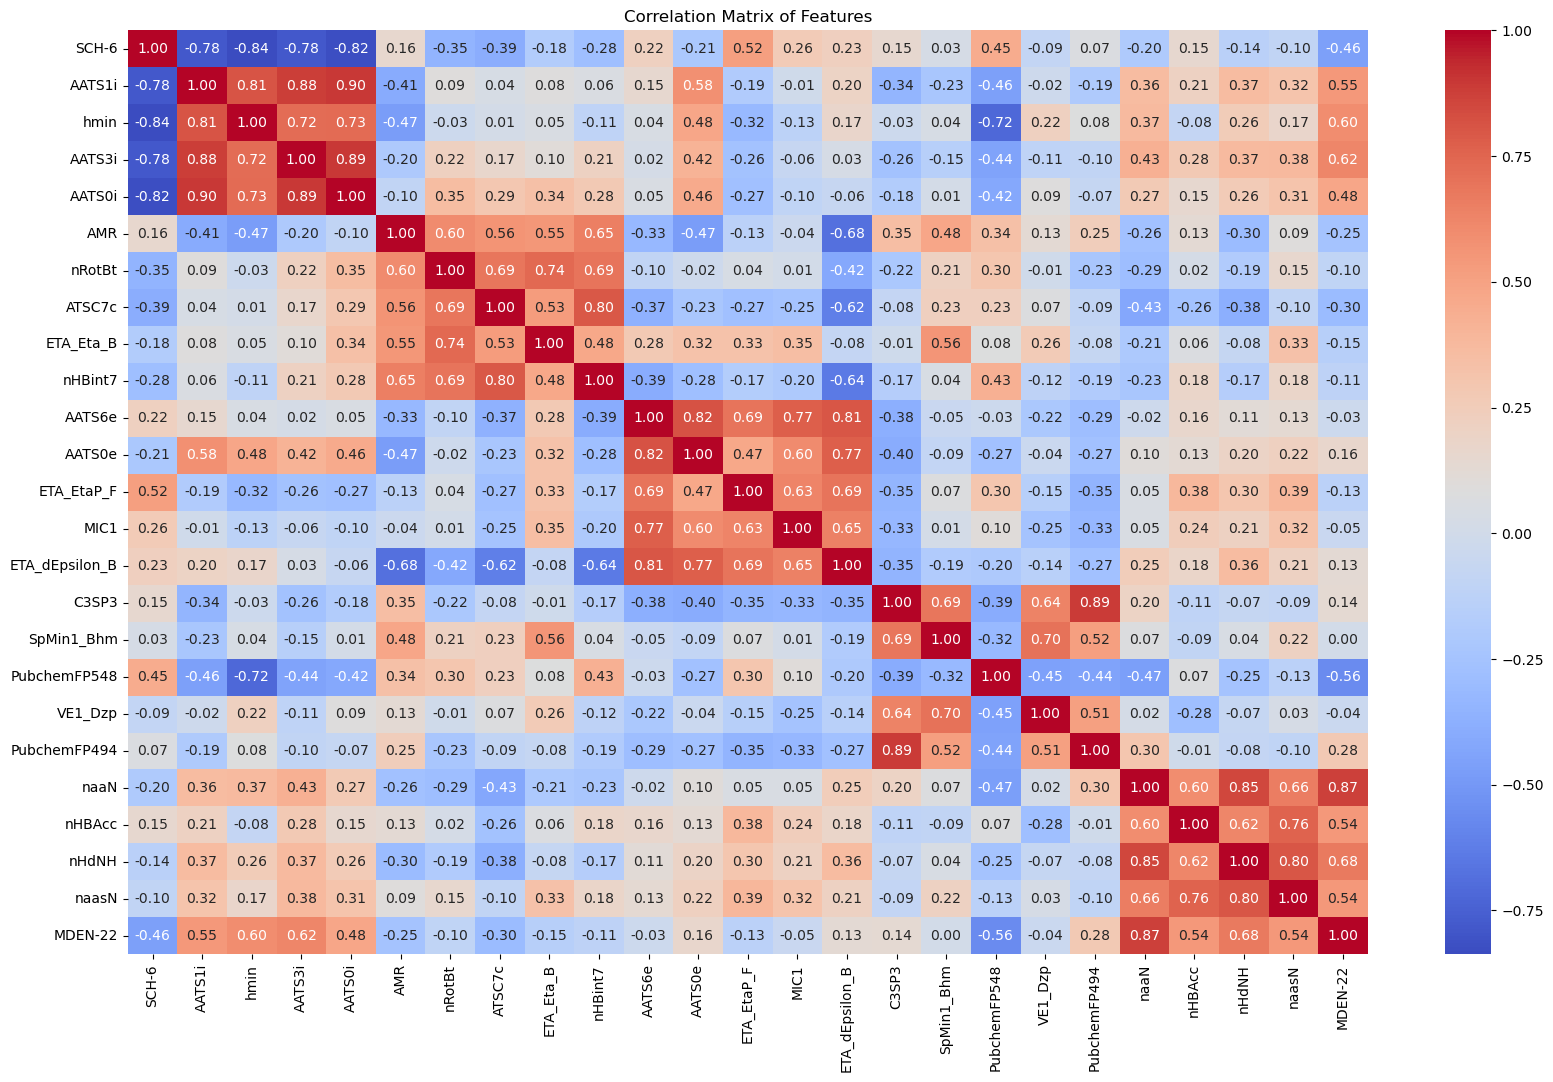

In [112]:
X = df2[features_to_use]
correlation_matrix = X.corr()
plt.figure(figsize=(20, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Features")
# Save the figure as a PNG file
plt.savefig('correlation_heatmap.png', dpi=600)
plt.show()


In [122]:
correlation_matrix = X.corr().abs()
upper =correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape),k=1).astype(bool))
#dropping features above 0.8
features_to_drop = [column for column in upper.columns if any (upper[column]>0.8)]
df_new = df2.drop(columns =features_to_drop)
print(f'Features dropped >0.8: {features_to_drop}')
new_features = df2[[col for col in features_to_use if col not in features_to_drop]]
print(f'dataframe shape after drop: {new_features.shape}')

Features dropped >0.8: ['hmin', 'AATS3i', 'AATS0i', 'AATS0e', 'ETA_dEpsilon_B', 'PubchemFP494', 'nHdNH', 'naasN', 'MDEN-22']
dataframe shape after drop: (60, 16)


using all the descriptors I will then check the Permuation inportance of the top 5 descriptors using RF

In [150]:
new_features2 = ['SCH-6','AATS1i', 'AMR', 'nRotBt','ATSC7c','ETA_Eta_B','nHBint7',
                                            'AATS6e','ETA_EtaP_F','MIC1','C3SP3','SpMin1_Bhm','PubchemFP548','VE1_Dzp','naaN','nHBAcc']

- We have now identified our descriptors

In [184]:
#using RFE on Random Forest
from sklearn.feature_selection import RFE

X= df[new_features2]
y= df['pIC50']

# Scale the features
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=df.index)

# train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

estimator = RandomForestRegressor(n_estimators =100, random_state =42)
#doing RFE
selector =RFE(estimator,n_features_to_select=3,step=1)

selector=selector.fit(X_train,y_train)

selected_features =X_train.columns[selector.support_]

print('Selected features:')
print(selected_features)

X_train_selected =selector.transform(X_train)
X_test_selected = selector.transform(X_test)


Selected features:
Index(['AMR', 'ATSC7c', 'ETA_Eta_B'], dtype='object')


- Now that we have our descriptors we will split our data into 80:20 train\test. 

In [21]:
selected_features = ['AMR', 'ATSC7c', 'ETA_Eta_B']

In [23]:
X= df[selected_features]
y= df['pIC50']

# train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


print("X_train:", X_train.shape)
print("y_train", y_train.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape) 

X_train: (48, 3)
y_train (48,)
X_test: (12, 3)
y_test: (12,)


- Now that we have have specified the train_test_split, we are ready for ML. firstly, we will visualize the X-train, just to confirm things.The structures of the train data is reflected in the Supporting material, under Table S1.

In [58]:
X_train

,AMR,ATSC7c,ETA_Eta_B
molecule_chembl_id,,,
CHEMBL381467,56.1028,0.276489,0.31670
CHEMBL1172698,26.7559,-0.264946,0.26185
CHEMBL3781371,31.7113,-0.104155,0.12123
CHEMBL198317,47.8030,0.181834,0.26618
CHEMBL1777917,35.6192,0.055519,0.51731
CHEMBL1777915,31.9308,0.104028,0.38998
CHEMBL3780072,34.2759,0.105431,0.22739
CHEMBL1777913,24.6150,0.064161,0.32182
CHEMBL3780369,37.3269,-0.102675,0.21055


- We do the same for the X-test. Table S2 in under supporting material.

In [60]:
X_test

,AMR,ATSC7c,ETA_Eta_B
molecule_chembl_id,,,
CHEMBL1170766,25.6387,-0.334968,0.26185
CHEMBL1777914,30.2306,0.091663,0.42798
CHEMBL1096121,30.9145,-0.104085,0.08753
CHEMBL3780593,35.6013,-0.201113,0.31671
CHEMBL196076,52.2631,0.185775,0.40602
CHEMBL3781432,32.5838,-0.102096,0.21055
CHEMBL390333,27.2764,-0.169827,0.33865
CHEMBL3781110,37.2134,-0.133141,0.22739
CHEMBL1916856,27.1209,0.074513,0.28302


- Now we use the algorithms chosen to train our data.and do internal validation
- In the R2 train we check how the model fits on the training data. an R2 close to 1 indicates a good fit and it could also signal overfitting

- The R2 Test check how the model fits on the tesr data. An R2 close to 1 indicates good fit.

- Then we calculate the RMSE(LooV), a low RMSE means better prediction

- Then we check for Q2CV (LOOV) this quantifies the fraction of variance explained when each sample is left out in turn. the higher the number the better the model can explain the variance.



In [29]:
# name of models 
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Kernel Ridge': KernelRidge(),
    'KNN Regression': KNeighborsRegressor(),
    'Random Forest': RandomForestRegressor(random_state=1),
    'Gradient Boosting': GradientBoostingRegressor(random_state=1),
    'AdaBoost': AdaBoostRegressor(estimator=DecisionTreeRegressor(), n_estimators=50),
    'Decision Tree': DecisionTreeRegressor()}

#stacking model with base learners 
base_models = [
    ('rf', RandomForestRegressor(random_state=1)),
    ('ridge', Ridge(random_state=1)),
    ('ada', AdaBoostRegressor(estimator=DecisionTreeRegressor(), n_estimators=50))]

stacking_model = StackingRegressor(estimators=base_models, final_estimator=LinearRegression())
models['Stacking Regressor'] = stacking_model

#bagging model using Decision Tree as base estimator
bagging_model = BaggingRegressor(estimator=DecisionTreeRegressor(), n_estimators=10, random_state=1)

models['Bagging Regressor'] = bagging_model

#Function to evaluate a the measuring parameters
def evaluate_model(model):
    y_true_loocv = []
    y_pred_loocv = []

    loo = LeaveOneOut()
    
    for train_index, test_index in loo.split(X):
        X_train_loo, X_test_loo = X.iloc[train_index], X.iloc[test_index]
        y_train_loo, y_test_loo = y.iloc[train_index], y.iloc[test_index]
        
        model.fit(X_train_loo, y_train_loo)
        prediction = model.predict(X_test_loo)

        y_true_loocv.append(y_test_loo.values[0])
        y_pred_loocv.append(prediction[0])

    # Metrics for LOOCV
    mse_loocv = mean_squared_error(y_true_loocv, y_pred_loocv)
    rmse_loocv = np.sqrt(mse_loocv)
    r2_cv = r2_score(y_true_loocv, y_pred_loocv)

    return mse_loocv, rmse_loocv, r2_cv

results = []


for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)
    mse_loocv, rmse_loocv, r2_cv = evaluate_model(model)

    results.append({
        'Model': model_name,
        'R² Train': r2_train,
        'R² Test': r2_test,
        'RMSE (LOOCV)': rmse_loocv,
        'R² CV (LOOCV)': r2_cv,
    })


results_df = pd.DataFrame(results)


results_df

,Model,R² Train,R² Test,RMSE (LOOCV),R² CV (LOOCV)
0,Linear Regression,0.614271,0.546588,1.041044,0.505711
1,Ridge Regression,0.571981,0.414308,1.047815,0.499260
2,Kernel Ridge,-1.744665,-2.092927,2.488286,-1.823861
3,KNN Regression,0.639397,0.273469,1.137329,0.410050
4,Random Forest,0.960478,0.840294,0.800610,0.707662
5,Gradient Boosting,0.999447,0.854633,0.835420,0.681688
6,AdaBoost,0.999238,0.720690,0.863548,0.659893
7,Decision Tree,1.000000,0.420328,0.887695,0.640606
8,Stacking Regressor,0.889264,0.788529,0.830742,0.685243
9,Bagging Regressor,0.954598,0.695212,0.821950,0.691871


In [30]:
results_df.to_csv('regression_results.csv')

# Hyperparameter tuning
We will do Hyperparameter tuning for all the models

## Linear Regression

In [70]:
# Fit base model
base_model = LinearRegression()
base_model.fit(X_train, y_train)
r2_train_before = base_model.score(X_train, y_train)
r2_test_before = base_model.score(X_test, y_test)

#GridSearchCV
param_grid = {
    'fit_intercept': [True, False],
    'copy_X': [True, False],
    'positive': [True, False]
}
grid_search = GridSearchCV(estimator=LinearRegression(), param_grid=param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best model after tuning
best_model = grid_search.best_estimator_
r2_train_after = best_model.score(X_train, y_train)
r2_test_after = best_model.score(X_test, y_test)

# Print results
print("Best parameters found:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)
print("R2 train before tuning:", r2_train_before)
print("R2 test before tuning:", r2_test_before)
print("R2 train after tuning:", r2_train_after)
print("R2 test after tuning:", r2_test_after)


Best parameters found: {'copy_X': True, 'fit_intercept': True, 'positive': False}
Best cross-validation score: 0.5974061760355036
R2 train before tuning: 0.6142708986979986
R2 test before tuning: 0.5465880049506456
R2 train after tuning: 0.6142708986979986
R2 test after tuning: 0.5465880049506456


## Ridge Regression

In [72]:
# Fit base Ridge model
base_model = Ridge()
base_model.fit(X_train, y_train)
r2_train_before = base_model.score(X_train, y_train)
r2_test_before = base_model.score(X_test, y_test)

#parameter grid for alpha (regularization strength)
param_grid = {'alpha': [0.1, 1.0, 10.0, 100.0]}

# GridSearchCV for tuning alpha
grid_search = GridSearchCV(estimator=Ridge(), param_grid=param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best Ridge model after tuning
best_model = grid_search.best_estimator_
r2_train_after = best_model.score(X_train, y_train)
r2_test_after = best_model.score(X_test, y_test)

# Results output
print("Best alpha found:", grid_search.best_params_)
print("Best cross-validation R2 score:", grid_search.best_score_)
print("R2 train before tuning:", r2_train_before)
print("R2 test before tuning:", r2_test_before)
print("R2 train after tuning:", r2_train_after)
print("R2 test after tuning:", r2_test_after)


Best alpha found: {'alpha': 0.1}
Best cross-validation R2 score: 0.5915615241592139
R2 train before tuning: 0.5719811500258907
R2 test before tuning: 0.41430768438265564
R2 train after tuning: 0.6130127463968984
R2 test after tuning: 0.5375457395904237


## Random Forest

In [44]:
# Fit base Random Forest model
base_model = RandomForestRegressor(random_state=42)
base_model.fit(X_train, y_train)
r2_train_before = base_model.score(X_train, y_train)
r2_test_before = base_model.score(X_test, y_test)

#parameter grid for tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

# GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42), param_grid=param_grid, 
                           cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best model after tuning
best_model = grid_search.best_estimator_
r2_train_after = best_model.score(X_train, y_train)
r2_test_after = best_model.score(X_test, y_test)

# Print results
print("Best parameters found:", grid_search.best_params_)
print("Best cross-validation R2 score:", grid_search.best_score_)
print("R2 train before tuning:", r2_train_before)
print("R2 test before tuning:", r2_test_before)
print("R2 train after tuning:", r2_train_after)
print("R2 test after tuning:", r2_test_after)


Best parameters found: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}
Best cross-validation R2 score: 0.628680488738946
R2 train before tuning: 0.9614877489863689
R2 test before tuning: 0.8577265456612533
R2 train after tuning: 0.9362739446903281
R2 test after tuning: 0.8948526676221591


## Stacking Model

In [62]:
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

#base models
base_models = [
    ('rf', RandomForestRegressor(random_state=1)),
    ('ridge', Ridge(random_state=1)),
    ('ada', AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=1), n_estimators=50, random_state=1))
]

# Create stacking model with Linear Regression as meta model
stacking_model = StackingRegressor(estimators=base_models, final_estimator=LinearRegression())

# Fit base stacking model to get R2 before tuning
stacking_model.fit(X_train, y_train)
r2_train_before = stacking_model.score(X_train, y_train)
r2_test_before = stacking_model.score(X_test, y_test)

# Optionally define a parameter grid for tuning meta model and base estimators
param_grid = {
    'final_estimator__fit_intercept': [True, False],
    'ada__n_estimators': [50, 100],
    'ridge__alpha': [0.1, 1.0, 10.0]
}

# Use GridSearchCV to tune stacking model hyperparameters
grid_search = GridSearchCV(stacking_model, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
r2_train_after = best_model.score(X_train, y_train)
r2_test_after = best_model.score(X_test, y_test)

print("Best parameters found:", grid_search.best_params_)
print("R2 train before tuning:", r2_train_before)
print("R2 test before tuning:", r2_test_before)
print("R2 train after tuning:", r2_train_after)
print("R2 test after tuning:", r2_test_after)


Best parameters found: {'ada__n_estimators': 50, 'final_estimator__fit_intercept': False, 'ridge__alpha': 0.1}
R2 train before tuning: 0.8499466205471955
R2 test before tuning: 0.7254755142766998
R2 train after tuning: 0.830938658067616
R2 test after tuning: 0.7497945672631483


## Decision Tree

In [50]:
# Fitting base Decision Tree model
base_model = DecisionTreeRegressor(random_state=42)
base_model.fit(X_train, y_train)
r2_train_before = base_model.score(X_train, y_train)
r2_test_before = base_model.score(X_test, y_test)

#parameter grid for tuning
param_grid = {
    'max_depth': [None, 5, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(estimator=DecisionTreeRegressor(random_state=42), param_grid=param_grid, 
                           cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best model after tuning
best_model = grid_search.best_estimator_
r2_train_after = best_model.score(X_train, y_train)
r2_test_after = best_model.score(X_test, y_test)

# Print results
print("Best parameters found:", grid_search.best_params_)
print("Best cross-validation R2 score:", grid_search.best_score_)
print("R2 train before tuning:", r2_train_before)
print("R2 test before tuning:", r2_test_before)
print("R2 train after tuning:", r2_train_after)
print("R2 test after tuning:", r2_test_after)


Best parameters found: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2}
Best cross-validation R2 score: 0.47305038593113924
R2 train before tuning: 1.0
R2 test before tuning: 0.5913669738973405
R2 train after tuning: 0.8501960303427256
R2 test after tuning: 0.873262663072125


## Gradient Boost

In [63]:
# Training baseline model
default_model = GradientBoostingRegressor(random_state=1)
default_model.fit(X_train, y_train)

r2_train_before = default_model.score(X_train, y_train)
r2_test_before = default_model.score(X_test, y_test)

# Grid search setup
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'max_features': [None, 'sqrt', 'log2']  # 'auto' replaced by None
}

grid_search = GridSearchCV(
    estimator=GradientBoostingRegressor(random_state=1),
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

# Best tuned model
best_model = grid_search.best_estimator_
r2_train_after = best_model.score(X_train, y_train)
r2_test_after = best_model.score(X_test, y_test)

# Results output
print("Best hyperparameters found:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)
print("R2 train before tuning:", r2_train_before)
print("R2 test before tuning:", r2_test_before)
print("R2 train after tuning:", r2_train_after)
print("R2 test after tuning:", r2_test_after)


Best hyperparameters found: {'learning_rate': 0.01, 'max_depth': 3, 'max_features': 'sqrt', 'n_estimators': 300, 'subsample': 0.8}
Best cross-validation score: -0.8997497415617701
R2 train before tuning: 0.9994473043136544
R2 test before tuning: 0.85463348974039
R2 train after tuning: 0.9653780659276511
R2 test after tuning: 0.8481766949926175


## AdaBoost

In [64]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures


pipeline = Pipeline([
    ('poly_features', PolynomialFeatures()),
    ('adaboost', AdaBoostRegressor(estimator=DecisionTreeRegressor(), random_state=42))
])

param_grid = {
    'poly_features__degree': [1, 2],
    'adaboost__n_estimators': [50, 100, 200],
    'adaboost__learning_rate': [0.01, 0.1, 1.0],
    'adaboost__estimator__max_depth': [1, 2, 3]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
r2_train_after = best_model.score(X_train, y_train)
r2_test_after = best_model.score(X_test, y_test)

print("Best parameters found:", grid_search.best_params_)
print("R2 train after tuning:", r2_train_after)
print("R2 test after tuning:", r2_test_after)


Best parameters found: {'adaboost__estimator__max_depth': 2, 'adaboost__learning_rate': 0.01, 'adaboost__n_estimators': 50, 'poly_features__degree': 1}
R2 train after tuning: 0.8872231650669862
R2 test after tuning: 0.8883345128147265


## Bagging

In [65]:
# Base Bagging model using Decision Tree as base estimator
base_model = BaggingRegressor(estimator=DecisionTreeRegressor(), n_estimators=10, random_state=42)
base_model.fit(X_train, y_train)
r2_train_before = base_model.score(X_train, y_train)
r2_test_before = base_model.score(X_test, y_test)

#tuning number of base estimators and max_samples
param_grid = {
    'n_estimators': [10, 50, 100],
    'max_samples': [0.5, 0.75, 1.0],
    'max_features': [0.5, 0.75, 1.0]
}

# GridSearchCV for tuning Bagging Regressor
grid_search = GridSearchCV(BaggingRegressor(estimator=DecisionTreeRegressor(), random_state=42), 
                           param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best Bagging model after tuning
best_model = grid_search.best_estimator_
r2_train_after = best_model.score(X_train, y_train)
r2_test_after = best_model.score(X_test, y_test)

print("Best parameters found:", grid_search.best_params_)
print("Best cross-validation R2 score:", grid_search.best_score_)
print("R2 train before tuning:", r2_train_before)
print("R2 test before tuning:", r2_test_before)
print("R2 train after tuning:", r2_train_after)
print("R2 test after tuning:", r2_test_after)


Best parameters found: {'max_features': 1.0, 'max_samples': 0.75, 'n_estimators': 100}
Best cross-validation R2 score: 0.6455021994331294
R2 train before tuning: 0.9582514438155249
R2 test before tuning: 0.7337866113190645
R2 train after tuning: 0.9336904917728189
R2 test after tuning: 0.8764484837299491


## Kernel Ridge

In [68]:
# Base Kernel Ridge model
base_model = KernelRidge(kernel='linear', alpha=1.0)
base_model.fit(X_train, y_train)
r2_train_before = base_model.score(X_train, y_train)
r2_test_before = base_model.score(X_test, y_test)

# Parameter grid for tuning kernel type and regularization alpha
param_grid = {
    'alpha': [0.1, 1.0, 10.0],
    'kernel': ['linear', 'polynomial', 'rbf'],
    'degree': [3, 4],         # only used for polynomial kernel
    'gamma': [0.1, 0.01],     # used for rbf and polynomial
    'coef0': [0, 1]           # used for polynomial kernel
}

# GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(KernelRidge(), param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best model after tuning
best_model = grid_search.best_estimator_
r2_train_after = best_model.score(X_train, y_train)
r2_test_after = best_model.score(X_test, y_test)

print("Best parameters found:", grid_search.best_params_)
print("R2 train before tuning:", r2_train_before)
print("R2 test before tuning:", r2_test_before)
print("R2 train after tuning:", r2_train_after)
print("R2 test after tuning:", r2_test_after)


Best parameters found: {'alpha': 0.1, 'coef0': 1, 'degree': 3, 'gamma': 0.1, 'kernel': 'polynomial'}
R2 train before tuning: -1.7446647619337585
R2 test before tuning: -2.092926954461273
R2 train after tuning: 0.7297012626400967
R2 test after tuning: 0.4993809268711449


## Knn

In [76]:

# Base model without tuning
knn = KNeighborsRegressor()
knn.fit(X_train, y_train)

r2_train_before = knn.score(X_train, y_train)
r2_test_before = knn.score(X_test, y_test)

print("R2 train before tuning:", r2_train_before)
print("R2 test before tuning:", r2_test_before)

# Hyperparameter grid
param_grid = {
    'n_neighbors': list(range(1, 31)),          # neighbors from 1 to 30
    'weights': ['uniform', 'distance'],          # uniform or distance based weights
    'p': [1, 2]                                  # p=1: Manhattan, p=2: Euclidean distance
}

grid_search = GridSearchCV(KNeighborsRegressor(), param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_knn = grid_search.best_estimator_
r2_train_after = best_knn.score(X_train, y_train)
r2_test_after = best_knn.score(X_test, y_test)

print("Best parameters found:", grid_search.best_params_)
print("R2 train after tuning:", r2_train_after)
print("R2 test after tuning:", r2_test_after)


R2 train before tuning: 0.6393971461980329
R2 test before tuning: 0.2734686402922274
Best parameters found: {'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
R2 train after tuning: 0.7278394739886305
R2 test after tuning: 0.5111544243655726


# Now we fitting the models using the optimal hyperparameters

In [78]:
#models 
base_estimator = DecisionTreeRegressor(max_depth=2)

models = {
    'Linear Regression': LinearRegression(copy_X=True, fit_intercept=True, positive=False),
    'Ridge Regression': Ridge(alpha=0.1),
    'Kernel Ridge': KernelRidge(alpha=0.1, coef0=1, degree=3, gamma=0.1, kernel='polynomial'),
    'KNN Regression': KNeighborsRegressor(n_neighbors=3, p=1, weights='uniform'),  
    'Random Forest': RandomForestRegressor(max_depth=None, min_samples_split=5, n_estimators=200, random_state=1),
    'Gradient Boosting': GradientBoostingRegressor(random_state=1),  # no parameters specified
    'AdaBoost': AdaBoostRegressor(
        estimator=base_estimator,
        n_estimators=50,
        learning_rate=0.01,
        random_state=42
    ),
    'Decision Tree': DecisionTreeRegressor(max_depth=None, min_samples_leaf=4, min_samples_split=2)
}

#stacking model with base learners 
base_models = [
    ('rf', RandomForestRegressor(random_state=1)),
    ('ridge', Ridge(random_state=1)),
    ('ada', AdaBoostRegressor(estimator=DecisionTreeRegressor(), n_estimators=50))
]

stacking_model = StackingRegressor(estimators=base_models, final_estimator=LinearRegression())
models['Stacking Regressor'] = stacking_model

#bagging model using Decision Tree as base estimator
bagging_model = BaggingRegressor(estimator=DecisionTreeRegressor(), n_estimators=10, random_state=1)

models['Bagging Regressor'] = bagging_model

#Function to evaluate a the measuring parameters
def evaluate_model(model):
    y_true_loocv = []
    y_pred_loocv = []

    loo = LeaveOneOut()
    
    for train_index, test_index in loo.split(X):
        X_train_loo, X_test_loo = X.iloc[train_index], X.iloc[test_index]
        y_train_loo, y_test_loo = y.iloc[train_index], y.iloc[test_index]
        
        model.fit(X_train_loo, y_train_loo)
        prediction = model.predict(X_test_loo)

        y_true_loocv.append(y_test_loo.values[0])
        y_pred_loocv.append(prediction[0])

    # Calculate metrics for LOOCV
    mse_loocv = mean_squared_error(y_true_loocv, y_pred_loocv)
    rmse_loocv = np.sqrt(mse_loocv)
    r2_cv = r2_score(y_true_loocv, y_pred_loocv)

    return mse_loocv, rmse_loocv, r2_cv

# results stored a list
results = []


for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)
    mse_loocv, rmse_loocv, r2_cv = evaluate_model(model)

    results.append({
        'Model': model_name,
        'R² Train': r2_train,
        'R² Test': r2_test,
        'RMSE (LOOCV)': rmse_loocv,
        'R² CV (LOOCV)': r2_cv,
    })


results_df = pd.DataFrame(results)


results_df

,Model,R² Train,R² Test,RMSE (LOOCV),R² CV (LOOCV)
0,Linear Regression,0.614271,0.546588,1.041044,0.505711
1,Ridge Regression,0.613013,0.537546,1.034381,0.512018
2,Kernel Ridge,0.729701,0.499381,1.041221,0.505543
3,KNN Regression,0.727839,0.511154,1.123295,0.424519
4,Random Forest,0.936025,0.898360,0.761285,0.735675
5,Gradient Boosting,0.999447,0.854633,0.835420,0.681688
6,AdaBoost,0.899911,0.893458,0.883129,0.644294
7,Decision Tree,0.850196,0.873263,0.867496,0.656775
8,Stacking Regressor,0.925715,0.792411,0.826083,0.688764
9,Bagging Regressor,0.954598,0.695212,0.821950,0.691871


In [80]:
results_df.to_csv('regression_results_parameters.csv')

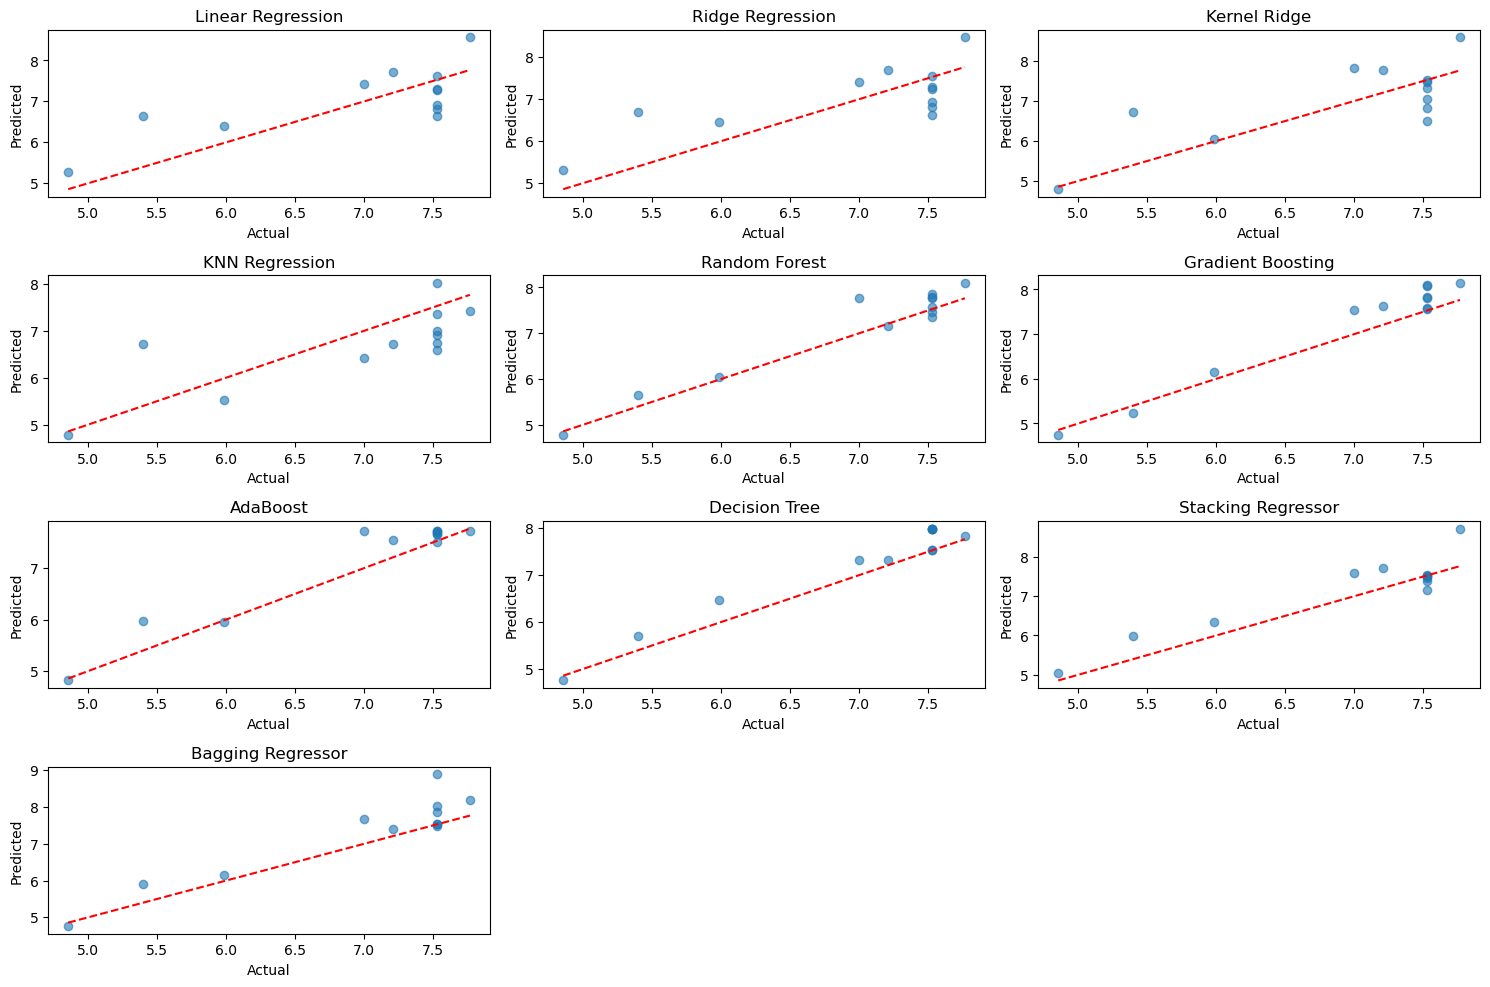

In [84]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 12))

for i, (name, model) in enumerate(models.items()):
    # Fit the model on training data
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    plt.subplot(5, 3, i + 1)

    #plt.subplot(4, 3, i + 1)
    plt.scatter(y_test, y_pred, alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.title(name)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')

plt.tight_layout()
plt.savefig('scatter_plots.png', dpi=600, bbox_inches='tight') 

plt.show()


In [35]:
results_df.to_csv('regress_results3.csv')

- The Adaboost model appears to be the best performing in terms of balance between the train and test variace and and as well as the RCV of which is higher at 71%.

- We now see optimal conditions that be used to give good performace. This will be achieved using GridSearchCV of 5.

- We can see the optimum conditions above. We then fit our model Adaboost and plot a scatter to see how it fits.

R2 train: 0.9360
R2 test: 0.8984


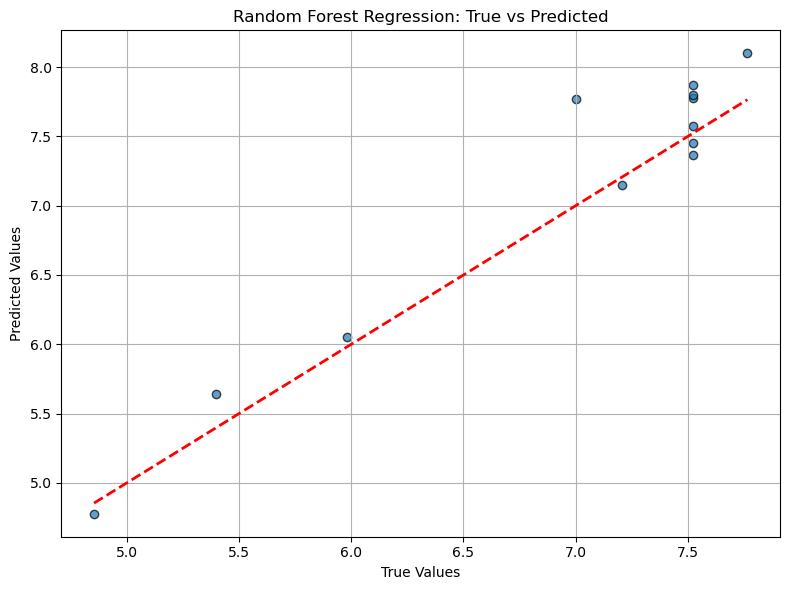

In [25]:
import matplotlib.pyplot as plt

# using best parameters
rf_model = RandomForestRegressor(
    max_depth=None,
    min_samples_split=5,
    n_estimators=200,
    random_state=1
)

# Fitting model on training data
rf_model.fit(X_train, y_train)

# Predict on test data
y_pred = rf_model.predict(X_test)

# Calculating R2 scores again
r2_train = rf_model.score(X_train, y_train)
r2_test = rf_model.score(X_test, y_test)

print(f"R2 train: {r2_train:.4f}")
print(f"R2 test: {r2_test:.4f}")

# Scatter plot: true vs predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7, edgecolors='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Random Forest Regression: True vs Predicted')
plt.grid(True)
plt.tight_layout()

# Save plot before showing
plt.savefig('scatter_rf.png', dpi=600, bbox_inches='tight') 

plt.show()

# Save results to Excel file
#df_results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
#df_results.to_excel('ada_boost_predictions.xlsx', index=False)


In [90]:
import pandas as pd


feature_names = X_train.columns if hasattr(X_train, 'columns') else [f'Feature_{i}' for i in range(X_train.shape[1])]

#importances from RF model
feature_importances = rf_model.feature_importances_

# C=Df of feature importance
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df)


     Feature  Importance
1     ATSC7c    0.622493
0        AMR    0.234338
2  ETA_Eta_B    0.143169


- Now we want to visualize the scatter plot and see how the models look.

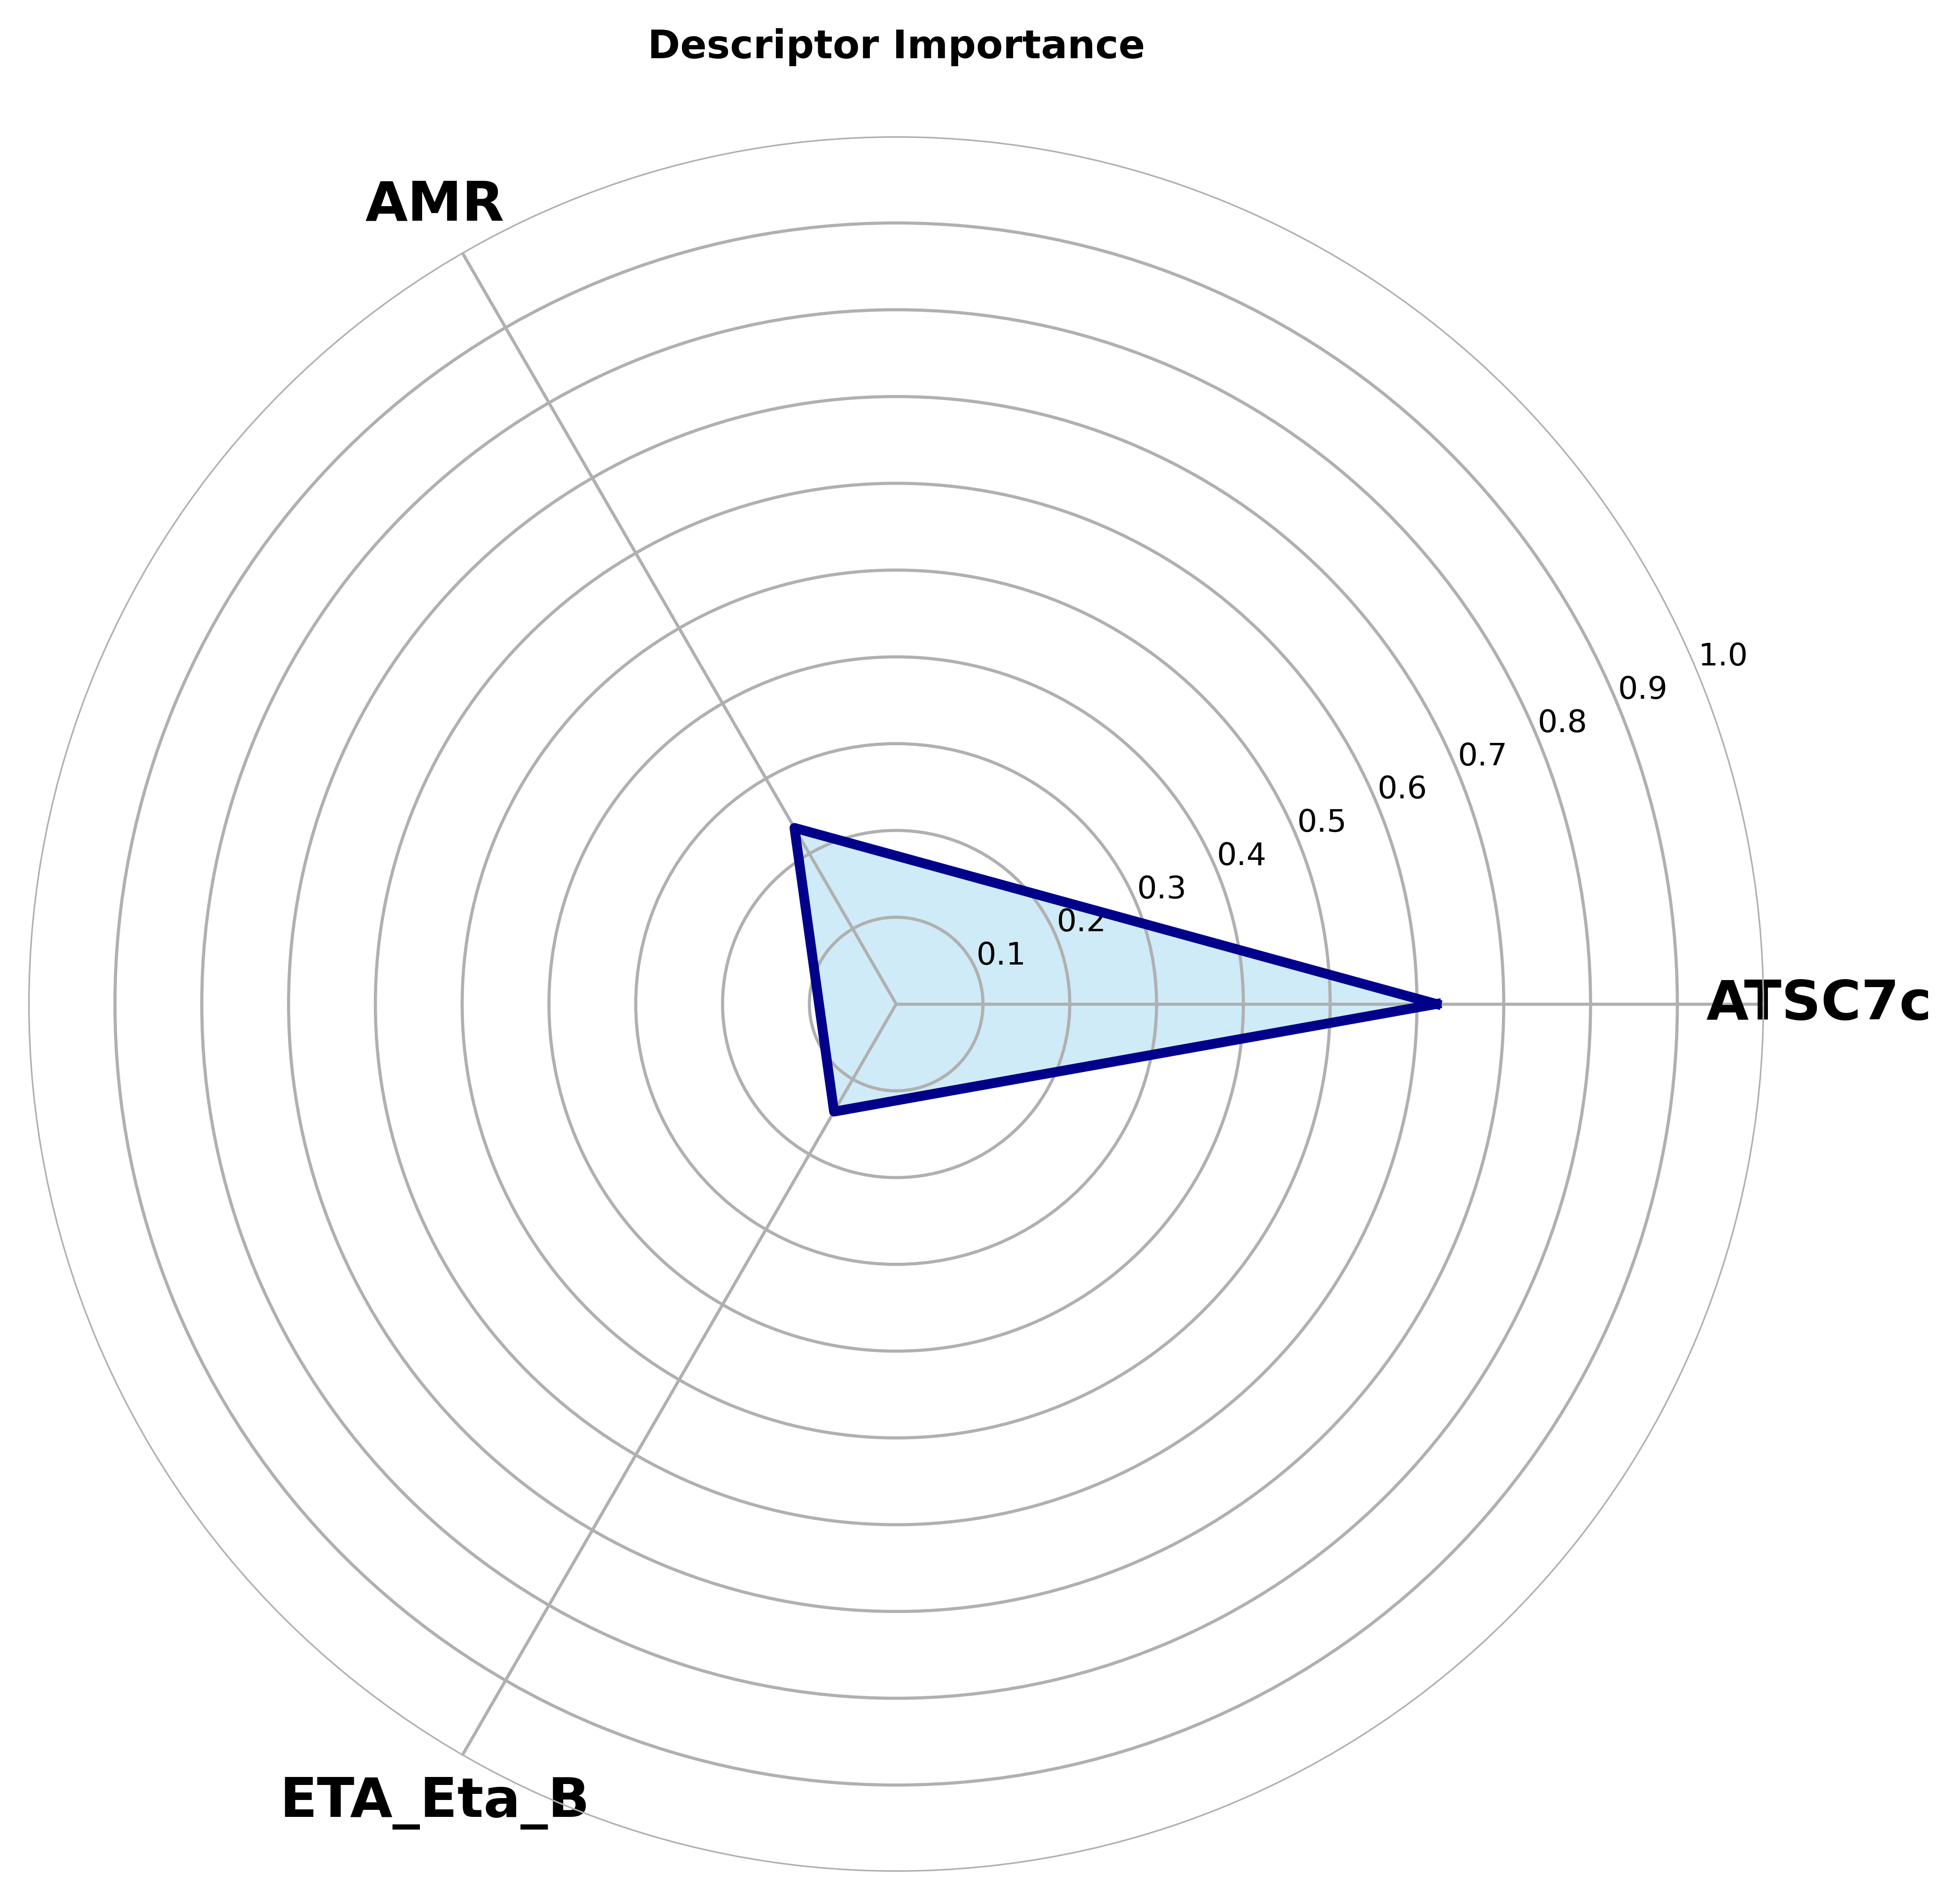

In [98]:
features = ['ATSC7c', 'AMR', 'ETA_Eta_B']
importance= [ 0.622493, 0.234338,  0.143169]

#angle for each axis in radians
num_vars = len(importance)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

importance += importance[:1]
angles += angles[:1]


fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True), dpi=600)
ax.plot(angles, importance, color='darkblue', linewidth=2.5, linestyle='solid')
ax.fill(angles, importance, color='skyblue', alpha=0.4)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(features, fontsize=14, fontweight='bold')

ax.set_ylim(0, 0.5)
ax.tick_params(axis='y', labelsize=10)
ax.set_yticks([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
ax.set_yticklabels([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], fontsize=8)


ax.spines['polar'].set_visible(False)

plt.title('Descriptor Importance', fontsize=10, fontweight='bold', pad=20)

plt.savefig('Descriptor_importance_spider_plot.png', bbox_inches='tight', dpi=600)

plt.show()

### Validation
 Validation if the model is divided into two, external and internal. External focuses on the test data, while the internal is the training data. The model is validated according to the OECD principles and using Tropsha
 

### Internal validation
- Most of the parameters such as the R^2,RMSE. Q2 LOO, MAE have already been calculated. therefore, here we will calculate the 
1). Application domain of which According to the OECD principles, a QSAR model should be associated a Application Domain (AD) which can be calculated using the pairwise Euclidean distances between each compound in the training set and those in test set.
2). We will also calculate the y_randomization to make sure that that the prediction is not as a result of a chance.




# ADT
---

In [27]:
# Fit scaler on training data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Transform test data using the same scaler
X_test_scaled = scaler.transform(X_test)

# using pairwise Euclidean distances
distance = pairwise_distances(X_train_scaled, X_train_scaled, metric='euclidean')

#diagonal set to infinity
np.fill_diagonal(distance,np.inf)
#nearest distances
near_distances = np.min(distance, axis =1)
#average distance(D)
average_distance = np.mean(near_distances)
#sigma
sigma = np.std(near_distances)
#Z (set to be 0.5)
Z = 0.5
ADT = average_distance+ Z*sigma

print("Average Distance (D):", average_distance)
print("(Standard Deviation(σ) nearest_distances):", sigma)
print("Applicability Domain Threshold (ADT):", ADT)

#comparing the distances
compare_dist = pairwise_distances(X_test_scaled, X_train_scaled, metric='euclidean')
compare_dist_nearest = np.min(compare_dist)
print(compare_dist_nearest)
if compare_dist_nearest > ADT:
    result = 'predictionunreliable'
else:
    result = 'prediction reliable'
print(result)


Average Distance (D): 0.4859360312085806
(Standard Deviation(σ) nearest_distances): 0.31705718575143665
Applicability Domain Threshold (ADT): 0.6444646240842989
0.049308504556575
prediction reliable


C:\Users\sjtsi\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


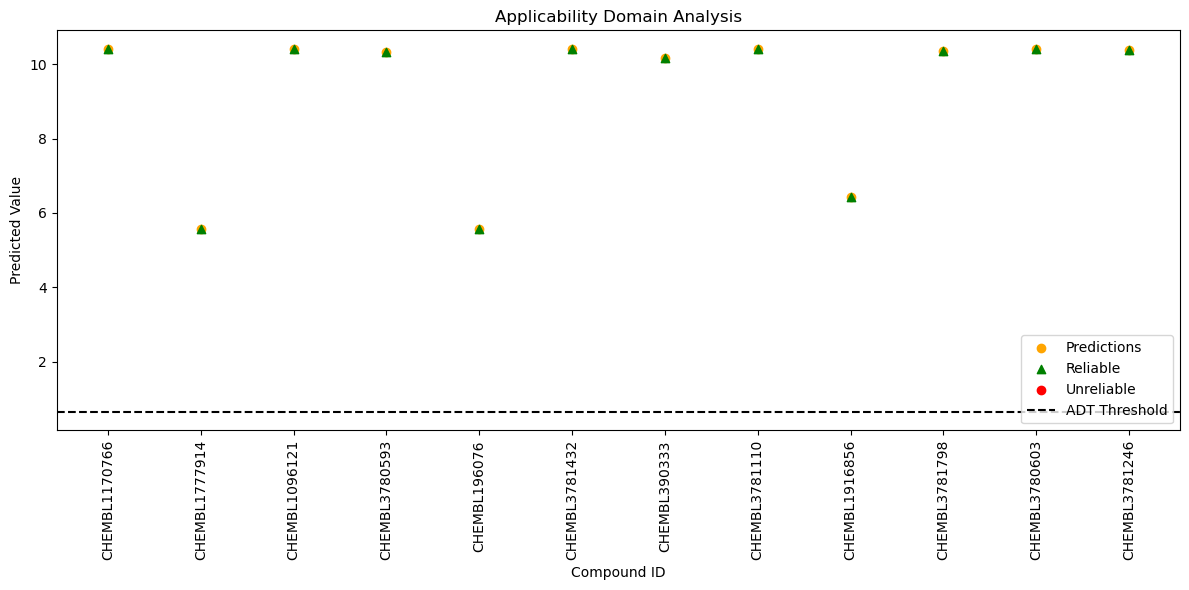

In [29]:
from scipy.spatial import distance_matrix

test_indices = X_test.index.to_numpy() 

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

predictions = rf_model.predict(X_test_scaled)

ADT = average_distance + Z * sigma

new_distances = distance_matrix(X_test_scaled, X_train_scaled)
new_nearest_distances = np.min(new_distances, axis=1) 
within_ad = new_nearest_distances <= ADT

reliable_predictions = predictions[within_ad]
unreliable_predictions = predictions[~within_ad]

df_results = pd.DataFrame({
    'Compound_ID': test_indices,
    'Prediction': predictions,
    'Reliable': within_ad
})
df_results.to_csv('predictions_with_reliability.csv', index=False)


plt.figure(figsize=(12, 6))
plt.scatter(test_indices, predictions, color='orange', label='Predictions')
plt.scatter(test_indices[within_ad], reliable_predictions, color='green', marker='^', label='Reliable')
plt.scatter(test_indices[~within_ad], unreliable_predictions, color='red', marker='o', label='Unreliable')
plt.axhline(y=ADT, color='black', linestyle='--', label='ADT Threshold')
plt.title('Applicability Domain Analysis')
plt.xlabel('Compound ID')
plt.ylabel('Predicted Value')
plt.legend(loc='lower right')


plt.xticks(rotation=90)


plt.tight_layout()
plt.savefig('applicability_domain_analysis.png', dpi=600)
plt.show()

y-shuffling
here,We want to check if the model is due to chance.

In [31]:
ypred = rf_model.predict(X_train)  
original_r2 = r2_score(y_train, ypred)

print("Original R²:",original_r2 )

shuffled_r2 = []  

for i in range(1000): 
    # Shuffling y_train..doing it 1000 times
    y_train_shuffled = y_train.sample(frac=1, random_state=i).reset_index(drop=True)  
    

    ypred_shuffled = rf_model.predict(X_train)  
    shuffled_r2.append(r2_score(y_train_shuffled, ypred_shuffled))
    
mean_shuffled_r2 = np.mean(shuffled_r2)
std_shuffled_r2 = np.std(shuffled_r2)


# Calculating cRp^2
R_r_squared = mean_shuffled_r2  
print("mean_shuffled_r^2 is:", R_r_squared)
cRp_squared = original_r2 * np.sqrt(original_r2 - R_r_squared)

#cRp^2 result
print("Adjusted Correlation Coefficient (cRp^2):", cRp_squared)

# checking acceptable leves , 05 of cRp^2
if cRp_squared > 0.5:
    print("The QSAR model is acceptable (cRp^2 > 0.5).")
else:
    print("The QSAR model is not acceptable (cRp^2 ≤ 0.5).")



# Checking if original R² is significantly higher than mean shuffled R²
if original_r2 > mean_shuffled_r2:
    print("The model's performance is significantly better than chance.")
else:
    print("The model's performance is not significantly better than chance.")
    
# Evaluate Adaboost usimg R²
def evaluate_model(model):
    y_true_loocv = []
    y_pred_loocv = []

    loo = LeaveOneOut()
    
    for train_index, test_index in loo.split(X):
        X_train_loo, X_test_loo = X.iloc[train_index], X.iloc[test_index]
        y_train_loo, y_test_loo = y.iloc[train_index], y.iloc[test_index]
        
        model.fit(X_train_loo, y_train_loo)
        prediction = model.predict(X_test_loo)

        y_true_loocv.append(y_test_loo.values[0])
        y_pred_loocv.append(prediction[0])

    # Calculating metrics for LOOCV
    mse_loocv = mean_squared_error(y_true_loocv, y_pred_loocv)
    rmse_loocv = np.sqrt(mse_loocv)
    r2_cv = r2_score(y_true_loocv, y_pred_loocv)

    return mse_loocv, rmse_loocv, r2_cv

results = []

Original R²: 0.9360249657563062
mean_shuffled_r^2 is: -0.7688871587845519
Adjusted Correlation Coefficient (cRp^2): 1.2221891728860186
The QSAR model is acceptable (cRp^2 > 0.5).
The model's performance is significantly better than chance.


## Golbraikh and Tropsha
---

In [32]:
#comparing R2 to the threshold 0.5
print('R^2 vs observed:', original_r2)
if original_r2 > 0.5:
    print(f"Q² is: {original_r2} therefore it is above 0.5 threshold and it is acceptable")
else:
    print(f"Q² is: {original_r2} therefore it is below 0.5 threshold and it is NOT acceptable")

# Calculation for adjusted R-squared
n = len(y_train) 
k = X_train.shape[1]  

adjusted_r_squared = 1 - ((1 - original_r2) * (n - 1)) / (n - k - 1)
print("Adjusted R^2:", adjusted_r_squared)
closeness = (original_r2 - adjusted_r_squared) /  original_r2
print(f'closeness is: {closeness}')

if closeness < 0.1:
    print(f"Closeness condition (R² - r₀²) / R² < 0.1 is satisfied.")
else:
    print("closeness condition (R² - r₀²) / R² > 0.1 is NOT satisfied.")

# Stability condition check, threshold = 0.3
stability = abs(original_r2  - adjusted_r_squared)
print(f'stability is: {stability}')
if stability < 0.3:
    print("Stability condition |R² - Adjusted R²| < 0.3 is satisfied.")
else:
    print("Stability condition |R² - Adjusted R²| > 0.3 is NOT satisfied.")
    mean_pred = np.mean(ypred)

    mean_true = np.mean(y_train)

#slope k using covariance and variance
k = np.cov(ypred, y_train)[0][1] / np.var(ypred)
print("Slope (k) of predicted vs observed at zero intercept:", k)

#slope (k') of observed vs predicted at zero intercept
k_prime = np.cov(y_train, ypred)[0][1] / np.var(y_train)
print("Slope (k') of observed vs predicted at zero intercept:", k_prime)




R^2 vs observed: 0.9360249657563062
Q² is: 0.9360249657563062 therefore it is above 0.5 threshold and it is acceptable
Adjusted R^2: 0.9316630316033271
closeness is: 0.004660061763902533
Closeness condition (R² - r₀²) / R² < 0.1 is satisfied.
stability is: 0.004361934152979141
Stability condition |R² - Adjusted R²| < 0.3 is satisfied.
Slope (k) of predicted vs observed at zero intercept: 1.1272016752887175
Slope (k') of observed vs predicted at zero intercept: 0.8739051378685462


## Calculating the rm metric

In [36]:
rm2 = 1-np.sqrt(abs(original_r2-adjusted_r_squared))
print(f'rm^2:{rm2}')

rm^2:0.933955059595915


References
1. Jackson, C.M., Esnouf, M.P., Winzor, D.J. and Duewer, D.L., 2007. Defining and measuring biological activity: applying the principles of metrology. Accreditation and quality assurance, 12, pp.283-294.
Swinney, D.C., 2011. Molecular mechanism of action (MMoA) in drug discovery. In Annual Reports in Medicinal Chemistry (Vol. 46, pp. 301-317). Academic Press.
2. Chitale, P., Lemenze, A.D., Fogarty, E.C., Shah, A., Grady, C., Odom-Mabey, A.R., Johnson, W.E., Yang, J.H., Eren, A.M., Brosch, R. and Kumar, P., 2022. A comprehensive update to the M ycobacterium tuberculosis H37Rv reference genome. Nature communications, 13(1), p.7068.
3. Rácz, A., Bajusz, D. and Héberger, K., 2019. Intercorrelation limits in molecular descriptor preselection for QSAR/QSPR. Molecular informatics, 38(8-9), p.1800154.


#### Credits
https://projects.volkamerlab.org/teachopencadd/talktorials/T002_compound_adme.html
- Data professor youtuber
- Genereative AI such as CHATGPT and Google AI studios to make codes readable, however, the authours take ownership of the content.